# Pip and Import

In [1]:
%%capture
# Install Dask or PyArrow for large dataset handling (optional)
%pip install dask pyarrow.

# Install TensorFlow and Keras for LSTM
%pip install tensorflow

# Install Hugging Face Transformers for FinBERT
%pip install transformers

# Install Torch for FinBERT model
%pip install torch

# Install NumPy and Pandas for data manipulation
%pip install numpy pandas

# Install Scikit-learn for data preprocessing and evaluation metrics
%pip install scikit-learn

# Install Matplotlib and Seaborn for data visualization
%pip install matplotlib seaborn

# Install Jupyter Notebook extensions (optional, for enhanced notebook features)
%pip install jupyter_contrib_nbextensions

# Install NLTK for text processing
%pip install nltk

# Install yfinance for stock data
%pip install yfinance

# Ensure TensorFlow is installed
%pip install tensorflow

# Install pandas_market_calendars for market calendars
%pip install pandas-market-calendars

# install wordcloud for word cloud visualization
%pip install wordcloud

# install scipy for scientific computing
%pip install scipy==1.10.1

# install gensim for word2vec
%pip install gensim

# install pandas_datareader for stock data
%pip install pandas_datareader

In [2]:
%%capture
# Import necessary libraries for the project
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('all')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_market_calendars as mcal
import gensim
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
IMPORT_FILES = True
TEST = False

# Imports & File Path Definition

In [4]:
import os
import pandas as pd

# Define the file path
file_path = "C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/all-the-news-2-1.csv"

# Check if the file exists
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found at {file_path}. Ensure the dataset is downloaded and placed correctly.")

# Load the dataset
news_df = pd.read_csv(file_path, low_memory=False)

# Build the date column by combining year, month, and day
news_df['date'] = pd.to_datetime(news_df[['year', 'month', 'day']])

# Convert to string format YYYY-MM-DD
news_df['date'] = news_df['date'].dt.strftime('%Y-%m-%d')

# Rename the column to 'Date'
news_df.rename(columns={'date': 'Date'}, inplace=True)

# Define the date range
start_date = "2016-01-01"
end_date = "2020-12-31"

# Filter the dataset for the date range
filtered_news = news_df.loc[(news_df['Date'] >= start_date) & (news_df['Date'] <= end_date)]

# Display the filtered dataset
print(filtered_news)

               Date  year  month  day       author  \
0        2016-12-09  2016   12.0    9  Lee Drutman   
1        2016-10-07  2016   10.0    7  Scott Davis   
2        2018-01-26  2018    1.0   26          NaN   
3        2019-06-27  2019    6.0   27          NaN   
4        2016-01-27  2016    1.0   27          NaN   
...             ...   ...    ...  ...          ...   
2688873  2020-04-01  2020    4.0    1          NaN   
2688874  2020-04-01  2020    4.0    1          NaN   
2688875  2020-04-01  2020    4.0    1          NaN   
2688876  2020-04-01  2020    4.0    1          NaN   
2688877  2020-04-01  2020    4.0    1          NaN   

                                                     title  \
0        We should take concerns about the health of li...   
1        Colts GM Ryan Grigson says Andrew Luck's contr...   
2             Trump denies report he ordered Mueller fired   
3        France's Sarkozy reveals his 'Passions' but in...   
4        Paris Hilton: Woman In Black For

#Data Exploration & Visualization


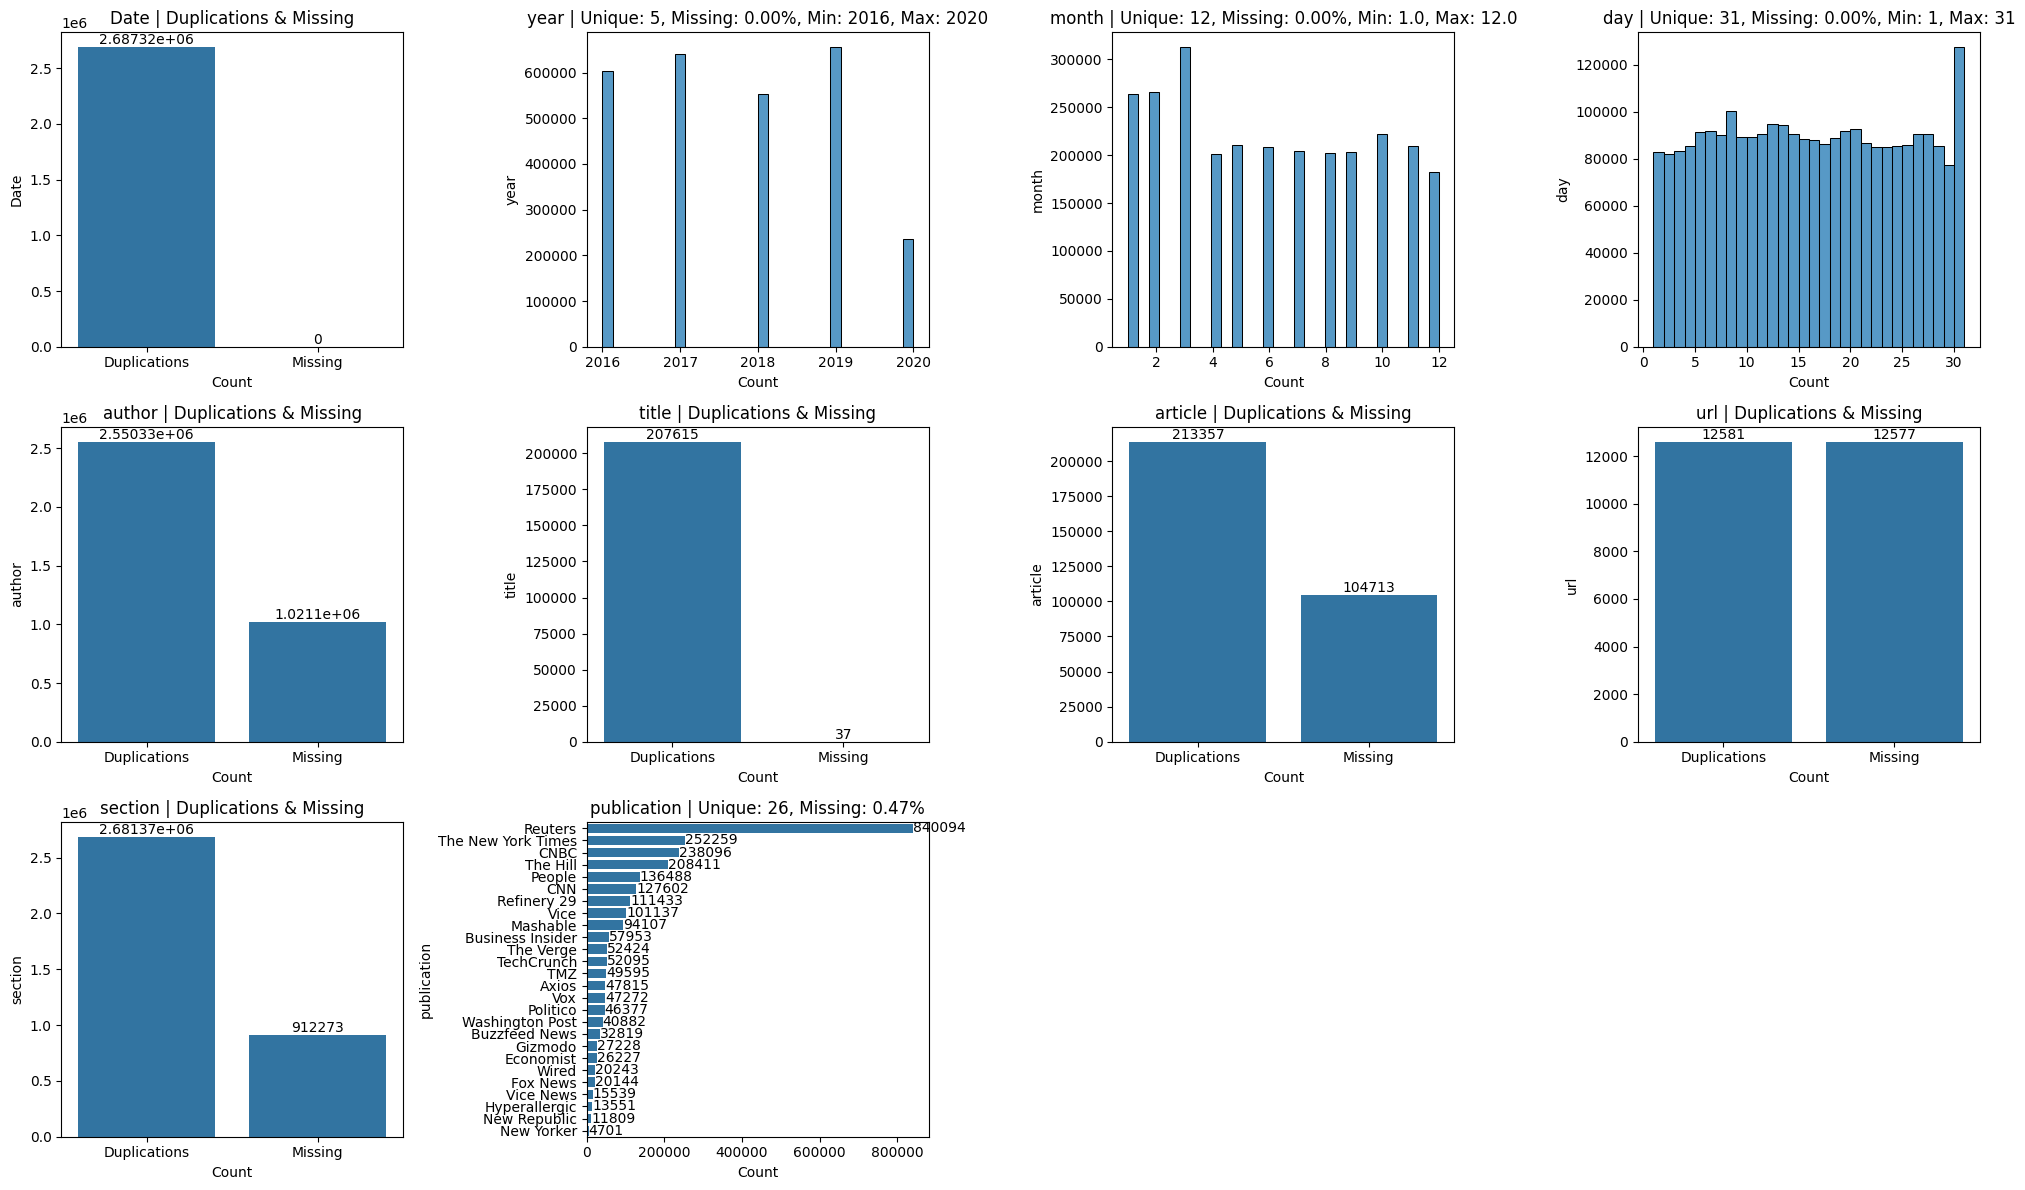

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Unified plotting function
def plot_columns(data):
    num_cols = len(data.columns)
    rows = (num_cols // 4) + (num_cols % 4 > 0)  # Create enough rows for 5 columns per row
    fig, axes = plt.subplots(rows, 4, figsize=(20, 12))
    axes = axes.flatten()
    
    for i, column in enumerate(data.columns):
        unique = data[column].nunique()
        missing = data[column].isnull().mean() * 100
        
        ax = axes[i]
        if pd.api.types.is_numeric_dtype(data[column]):
            sns.histplot(data[column].dropna(), kde=False, bins=30, ax=ax)
            ax.set_title(f"{column} | Unique: {unique}, Missing: {missing:.2f}%, Min: {data[column].min()}, Max: {data[column].max()}")
        elif column in ["publication"]:
            plot = sns.countplot(y=data[column], order=data[column].value_counts().index, ax=ax)
            plot.bar_label(plot.containers[0])
            ax.set_title(f"{column} | Unique: {unique}, Missing: {missing:.2f}%")
        else:
            dupes, nulls = data.duplicated(subset=[column]).sum(), data[column].isnull().sum()
            plot = sns.barplot(x=["Duplications", "Missing"], y=[dupes, nulls], ax=ax)
            plot.bar_label(plot.containers[0])
            ax.set_title(f"{column} | Duplications & Missing")
        ax.set_ylabel(column)
        ax.set_xlabel("Count")
        
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])  # Remove unused subplots
    
    plt.tight_layout()
    plt.show()

# Execute plotting
plot_columns(filtered_news)

#Duplicate Analysis & Visualization

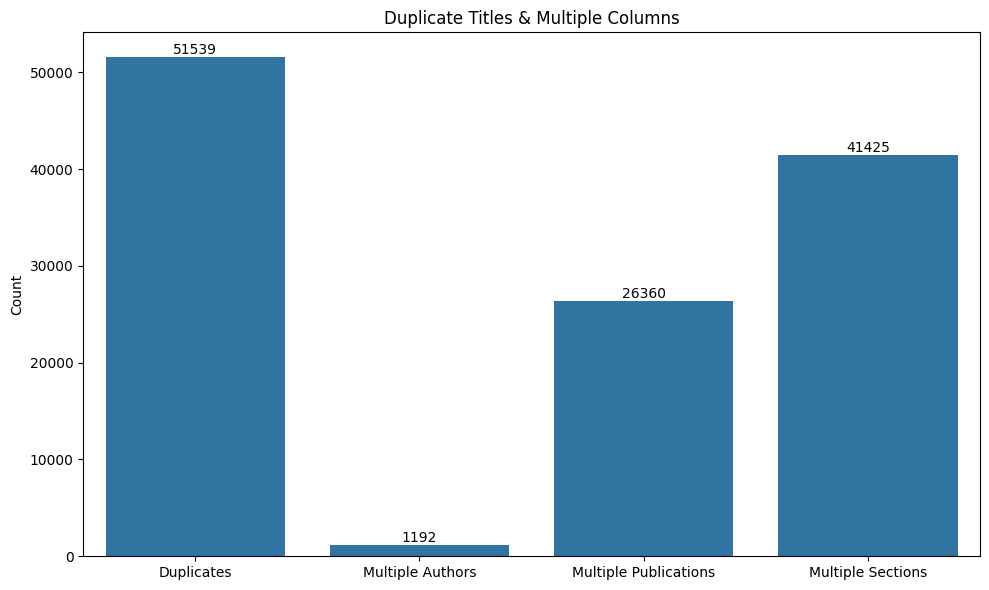

In [6]:
# Find duplicates based on title
duplicates = filtered_news[filtered_news.duplicated(subset='title', keep=False)]

# Group duplicates by title
grouped_duplicates = duplicates.groupby('title')

# Dictionary to hold details of duplicates
duplicate_details = {}

for title, group in grouped_duplicates:
    unique_publications = group['publication'].nunique()
    unique_dates = group['Date'].nunique()
    unique_authors = group['author'].nunique()
    unique_sections = group['section'].nunique()

    if unique_publications > 1 or unique_dates > 1 or unique_authors > 1 or unique_sections > 1:
        duplicate_details[title] = group

# Count the number of different duplicates
duplicates_count = len(duplicate_details)
multiple_authors = sum(group['author'].nunique() > 1 for group in duplicate_details.values())
multiple_publications = sum(group['publication'].nunique() > 1 for group in duplicate_details.values())
multiple_sections = sum(group['section'].nunique() > 1 for group in duplicate_details.values())

# Plot duplicate statistics
plt.figure(figsize=(10, 6))
plot = sns.barplot(x=["Duplicates", "Multiple Authors", "Multiple Publications", "Multiple Sections"],
                   y=[duplicates_count, multiple_authors, multiple_publications, multiple_sections])
plot.bar_label(plot.containers[0])
plt.title("Duplicate Titles & Multiple Columns")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#Data Cleaning

In [7]:
import gc

# Remove the duplicates by missing by policy provided above
before = len(filtered_news)

# MISSING VALUES 
# Remove the rows with missing values unless the column is an author or section
filtered_news = filtered_news.dropna(subset=['title', 'article', 'Date'])

# Remove the duplicate rows
filtered_news = filtered_news.drop_duplicates()

# Remove the duplicates from the filtered news dataset based on the title column and keep the first occurrence 
filtered_news = filtered_news.drop_duplicates(subset='title', keep='first')

# Now that we have found and removed all the duplicates, we can remove unnecessary columns, i.e., ones that will not be used in the analysis
filtered_news = filtered_news.drop(columns=['year', 'author', 'url', 'section', 'publication'])

after = len(filtered_news)

print(f"We have deleted {before - after} rows and we currently have {after} rows in our DataFrame")

gc.collect()

We have deleted 276857 rows and we currently have 2412021 rows in our DataFrame


181

#Financial News Filtering

In [8]:
# Define financial keywords
keywords = [
        'AAPL', 'Apple', 'Apple Inc.', 'iPhone', 'MacBook', 'iPad', 'Apple stock',
        'AMZN', 'Amazon', 'Amazon Inc.', 'AWS', 'Prime', 'Amazon stock'
        'NFLX', 'Netflix', 'Netflix Originals', 'Streaming', 'Netflix stock'
        'stock', 'stocks', 'shares', 'equity', 'price movement', 'market trends',
        'bull market', 'bear market', 'market volatility', 'earnings report',
        'quarterly results', 'forecast', 'valuation', 'trading volume', 'short squeeze',
        'revenue', 'profits', 'losses', 'dividends', 'growth', 'inflation',
        'recession', 'GDP', 'interest rates', 'policy changes'
]

# Create a regex pattern
keyword_pattern = '|'.join(keywords)

# Filter articles based on keywords
filtered_news = filtered_news[
    filtered_news['title'].str.contains(keyword_pattern, case=False, na=False) |
    filtered_news['article'].str.contains(keyword_pattern, case=False, na=False)
]

# Further refine by ensuring both title and article contain financial terms
filtered_news = filtered_news[
    (filtered_news['title'].str.contains(keyword_pattern, case=False, na=False)) &
    (filtered_news['article'].str.contains(keyword_pattern, case=False, na=False))
]

# Save the financial news dataset
# filtered_news_file_path = "C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/filtered_news.csv"
# filtered_news.to_csv(filtered_news_file_path, index=False)
data_head = filtered_news.head(10).copy()

# Truncate the strings in 'title' and 'article' columns
data_head['title'] = data_head['title'].apply(lambda x: x[:15] + '...' if len(x) > 15 else x)
data_head['article'] = data_head['article'].apply(lambda x: x[:15] + '...' if len(x) > 15 else x)


# creating a finanacial only dataset

In [9]:
data_head = filtered_news.copy()
# Initialize a 'Ticker' column with a default value of 'General'
filtered_news['Ticker'] = 'General'

# Define keyword groups for categorization
keywords = {
    'AAPL': ['AAPL', 'Apple', 'Apple Inc.', 'iPhone', 'MacBook', 'iPad', 'Apple stock'],
    'AMZN': ['AMZN', 'Amazon', 'Amazon Inc.', 'AWS', 'Prime', 'Amazon stock'],
    'NFLX': ['NFLX', 'Netflix', 'Netflix Originals', 'Streaming', 'Netflix stock'],
    'General': [
        'stock', 'stocks', 'shares', 'equity', 'price movement', 'market trends',
        'bull market', 'bear market', 'market volatility', 'earnings report',
        'quarterly results', 'forecast', 'valuation', 'trading volume', 'short squeeze',
        'revenue', 'profits', 'losses', 'dividends', 'growth', 'inflation',
        'recession', 'GDP', 'interest rates', 'policy changes'
    ]
}

# Function to categorize articles based on prioritization
def categorize_article(row):
    # Combine 'title' and 'article' for comprehensive keyword matching
    title = row['title'].lower() if isinstance(row['title'], str) else ''
    article = row['article'].lower() if isinstance(row['article'], str) else ''

    # Check title first
    for group, group_keywords in keywords.items():
        if any(keyword.lower() in title for keyword in group_keywords):
            # Return the first matching group unless it is 'General'
            if group != 'General':
                return group

    # If no match in title, check article
    for group, group_keywords in keywords.items():
        if any(keyword.lower() in article for keyword in group_keywords):
            return group

    # Default to 'General' if no match
    return 'General'

# Apply the categorization function to each row
filtered_news['Ticker'] = filtered_news.apply(categorize_article, axis=1)


#Stock Market & News Frequency Analysis

title colmn is type object
 38    Forget Facebook, Amazon or Google. Up-and-comi...
Name: title, dtype: object
Filtered news date range: 2016-01-01 00:00:00 to 2020-04-01 00:00:00
Number of days with zero articles for at least one ticker: 215
AAPL - Days below Avg: 695, Days below Median: 623, Min: 0, Max: 143
AMZN - Days below Avg: 687, Days below Median: 596, Min: 0, Max: 138
General - Days below Avg: 542, Days below Median: 619, Min: 0, Max: 150
NFLX - Days below Avg: 689, Days below Median: 583, Min: 0, Max: 50


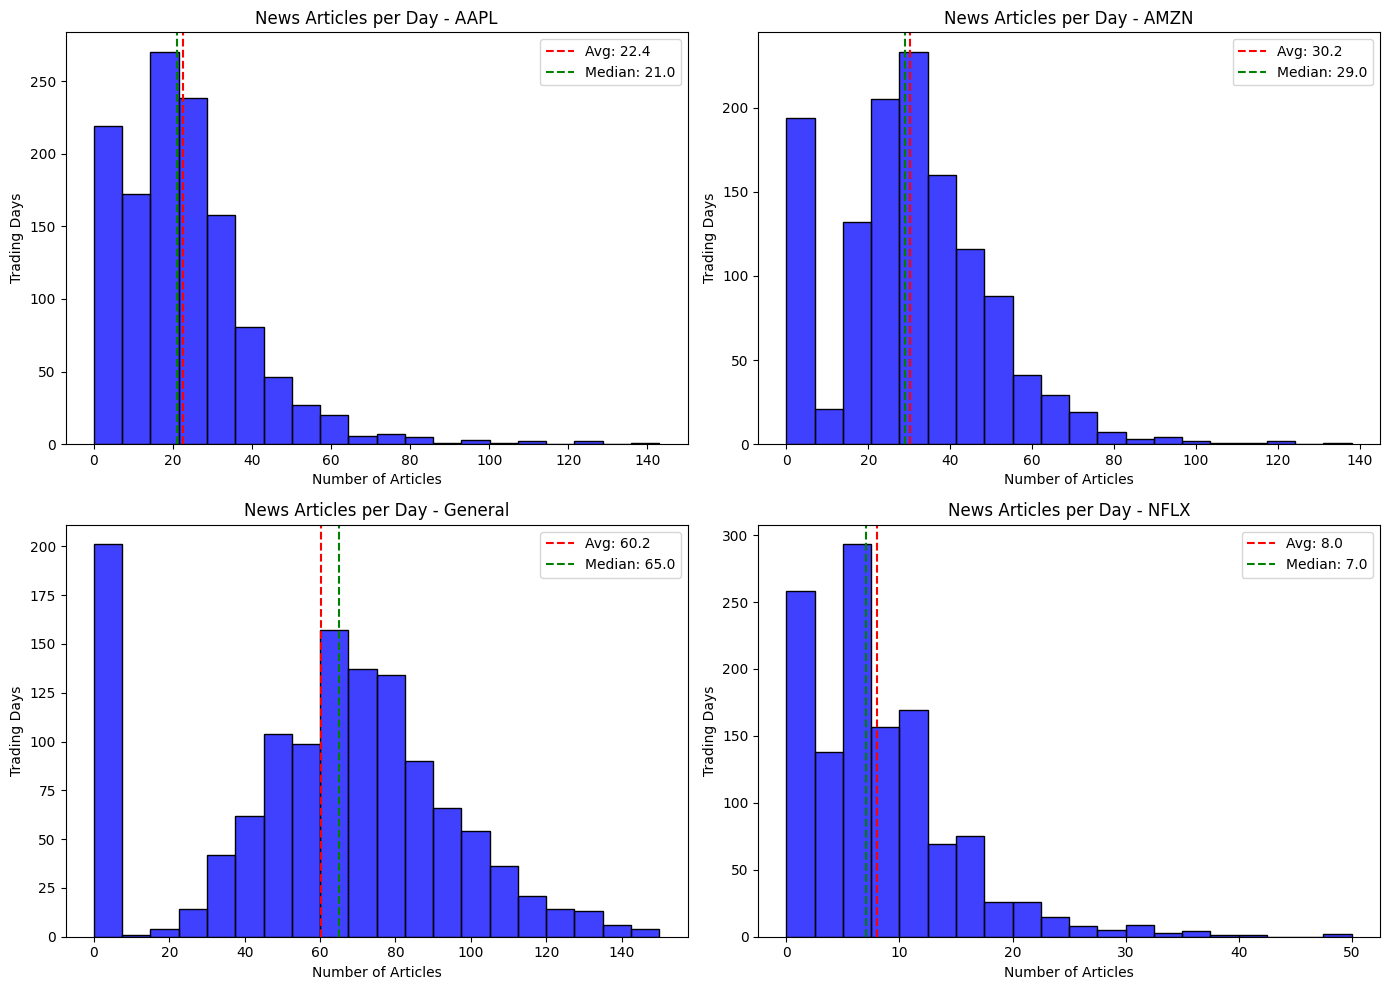

title colmn is type object
 38    Forget Facebook, Amazon or Google. Up-and-comi...
Name: title, dtype: object


In [10]:
import pandas as pd
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

print(f"title colmn is type {filtered_news['title'].dtype}\n",filtered_news['title'].head(1))
# Define the NYSE calendar
nyse = mcal.get_calendar('NYSE')

# Define date range
start_date = "2016-01-01"
end_date = "2021-01-01"

# Convert 'Date' column to datetime format
filtered_news['Date'] = pd.to_datetime(filtered_news['Date'])

# Check if any rows in 'filtered_news' are outside the valid date range
print(f"Filtered news date range: {filtered_news['Date'].min()} to {filtered_news['Date'].max()}")

# Group by 'Date' and 'Ticker' to count articles per day per stock
news_counts = filtered_news.groupby(['Date', 'Ticker']).size().unstack(fill_value=0)

# Get valid trading days from the NYSE calendar
trading_days = pd.to_datetime(nyse.valid_days(start_date=start_date, end_date=end_date))

# Remove any timezone information from trading_days to match filtered_news dates
trading_days = trading_days.tz_localize(None)

# Reindex to ensure all trading days are present (fill missing with 0)
news_counts = news_counts.reindex(trading_days, fill_value=0)

# Remove "noisy" data: Set values greater than 150 to NaN (or 0)
news_counts[news_counts > 150] = 0

# Count the number of days with 0 articles for at least one ticker
days_with_no_articles = (news_counts == 0).any(axis=1).sum()

# Print the count of days with zero articles for at least one ticker
print(f"Number of days with zero articles for at least one ticker: {days_with_no_articles}")

# Get tickers
tickers = news_counts.columns.tolist()

# Set up subplot grid (2x2 for up to 4 tickers)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

# Iterate over tickers and plot
for i, ticker in enumerate(tickers[:4]):  # Ensure we only plot up to 4 tickers
    ax = axes[i]
    sns.histplot(news_counts[ticker], bins=20, kde=False, ax=ax, color='blue')
    
    # Calculate statistics
    avg = news_counts[ticker].mean()
    median = news_counts[ticker].median()
    min_articles = news_counts[ticker].min()
    max_articles = news_counts[ticker].max()
    days_below_avg = (news_counts[ticker] < avg).sum()
    days_below_median = (news_counts[ticker] < median).sum()
    
    # Plot vertical lines for average and median
    ax.axvline(avg, color='red', linestyle='--', label=f'Avg: {avg:.1f}')
    ax.axvline(median, color='green', linestyle='--', label=f'Median: {median:.1f}')
    
    # Labels and title
    ax.set_title(f"News Articles per Day - {ticker}")
    ax.set_xlabel("Number of Articles")
    ax.set_ylabel("Trading Days")
    ax.legend()
    
    # Print stats
    print(f"{ticker} - Days below Avg: {days_below_avg}, Days below Median: {days_below_median}, Min: {min_articles}, Max: {max_articles}")

# Remove unused subplots if there are fewer than 4 tickers
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


print(f"title colmn is type {filtered_news['title'].dtype}\n",filtered_news['title'].head(1))

# Saving subset for testin

In [11]:
import gc
import pandas as pd

max_sample = 1 if TEST else 20

before = len(filtered_news)
    
# Count news articles per stock per day
news_counts = filtered_news.groupby(['Date', 'Ticker']).size().reset_index(name='count')

# Find the minimum news count on any day across all stocks
min_news_per_day = news_counts['count'].min()
min_news_date = news_counts[news_counts['count'] == min_news_per_day]['Date'].unique()

# Count how many stock-days have more than this minimum
above_min_count = (news_counts['count'] > min_news_per_day).sum()

# Apply filtering: randomly sample up to max_sample articles per date per ticker
filtered_news = (
   filtered_news.groupby(['Date', 'Ticker'])
   .apply(lambda x: x.sample(n=min(len(x), max_sample), random_state=42))
   .reset_index(drop=True))

# Free memory
gc.collect()

after = len(filtered_news)

print(f"We have deleted {before - after} rows and we currently have {after} rows in our DataFrame")


C:\Users\argam\AppData\Local\Temp\ipykernel_17332\3386366064.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), max_sample), random_state=42))


We have deleted 84998 rows and we currently have 80367 rows in our DataFrame


### Categorizing Financial News Articles

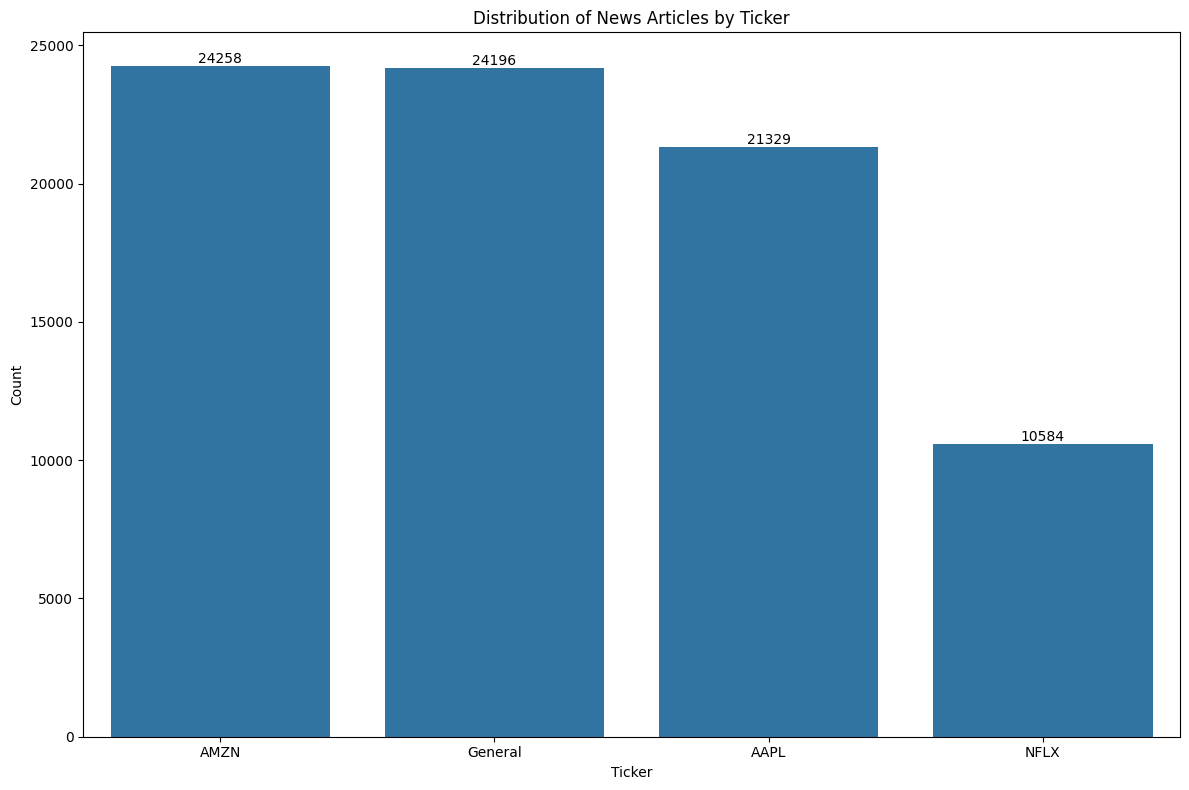

In [12]:
# Save the categorized news to a CSV file
# categorized_news_file_path = "C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/categorized_news.csv"
# filtered_news.to_csv(categorized_news_file_path, index=False)

# plot the distribution of the news articles by group with labels
plt.figure(figsize=(12, 8))
plot = sns.countplot(x=filtered_news['Ticker'], order=filtered_news['Ticker'].value_counts().index)
plot.bar_label(plot.containers[0])
plt.title("Distribution of News Articles by Ticker")
plt.xlabel("Ticker")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


# Text Normalization and Dimensionality Reduction in NLP

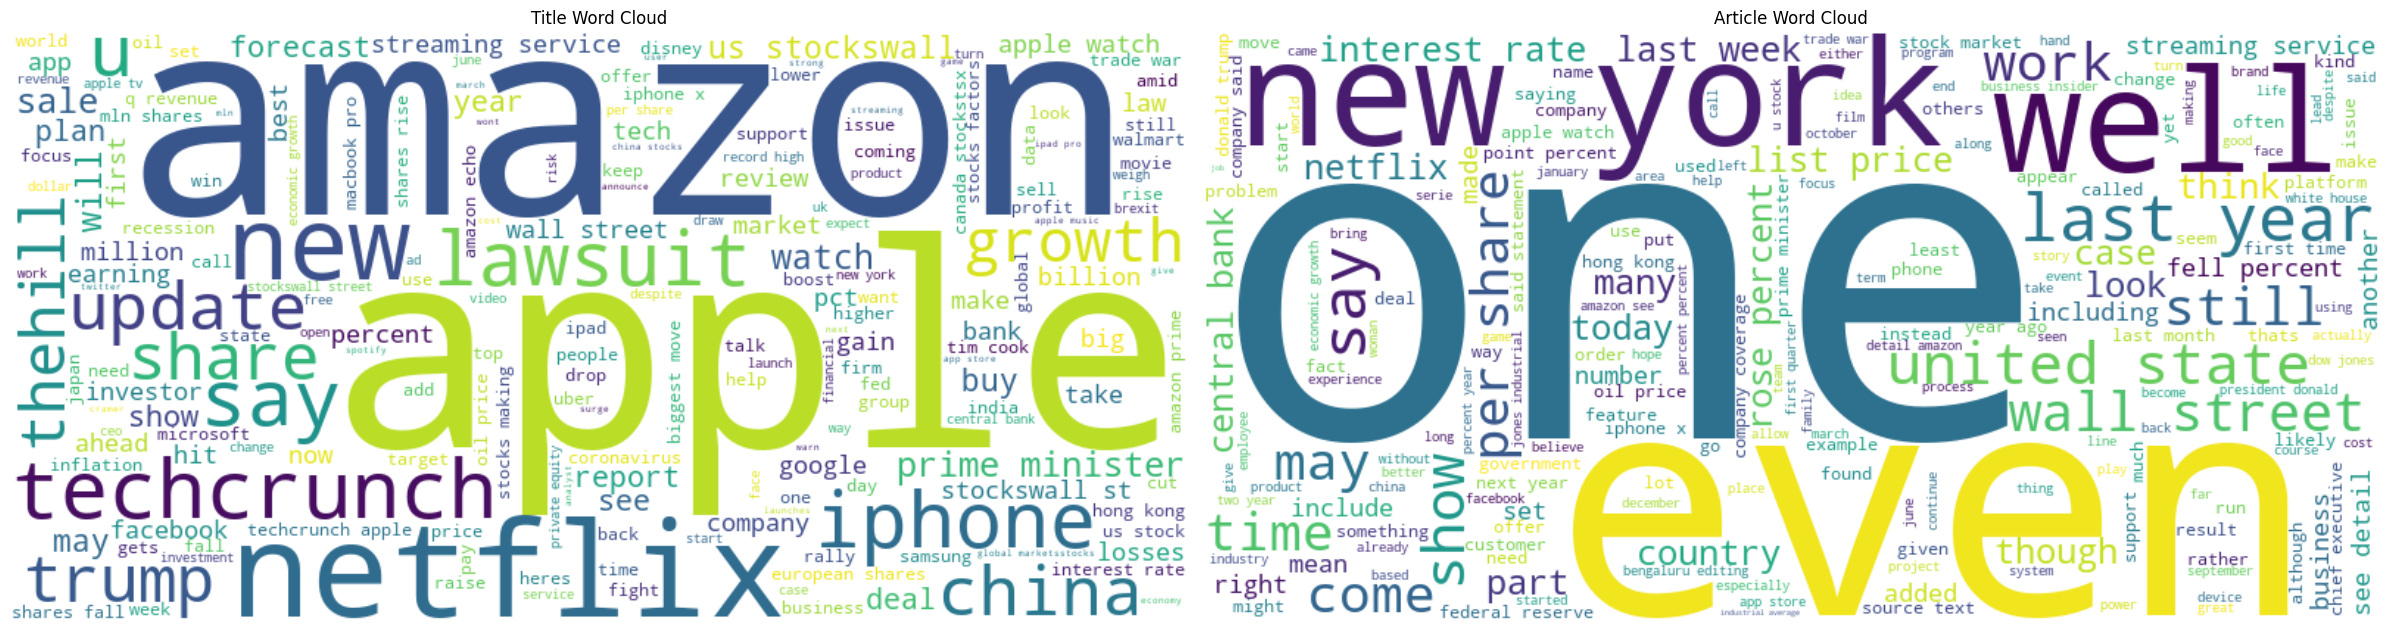

In [13]:
from nltk.tokenize import word_tokenize , RegexpTokenizer

# Normalize text
def normalize_text(text):
    return re.sub(r'[^a-z\s]', '', text.lower())

filtered_news['title'] = filtered_news['title'].apply(normalize_text)
filtered_news['article'] = filtered_news['article'].apply(normalize_text)

# Tokenize text
filtered_news['title'] = filtered_news['title'].apply(word_tokenize)
filtered_news['article'] = filtered_news['article'].apply(word_tokenize)

# Define custom stop words
financial_stopwords = {
    'aapl', 'apple', 'amzn', 'amazon', 'nflx', 'netflix', 'stock', 'shares',
    'market', 'growth', 'earnings', 'trading', 'revenue', 'profit', 'economy',
    'price', 'forecast', 'volatility', 'dividends', 'inflation', 'gdp',
    'interest', 'valuation'
}

general_stopwords = set(stopwords.words('english'))
all_stopwords = general_stopwords - financial_stopwords

# Remove stop words
def remove_stopwords(tokens):
    return [word for word in tokens if word not in all_stopwords]

filtered_news['article'] = filtered_news['article'].apply(remove_stopwords)

# Lemmatize text
lemmatizer = nltk.WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

filtered_news['article'] = filtered_news['article'].apply(lemmatize_tokens)

# Generate word clouds
def generate_wordcloud(text, title, ax):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(title)

all_titles = ' '.join([' '.join(tokens) for tokens in filtered_news['title']])
all_articles = ' '.join([' '.join(tokens) for tokens in filtered_news['article']])

fig, axs = plt.subplots(1, 2, figsize=(24, 12))

generate_wordcloud(all_titles, "Title Word Cloud", axs[0])
generate_wordcloud(all_articles, "Article Word Cloud", axs[1])

# Add space between the subplots
fig.subplots_adjust(wspace=0.5)

plt.tight_layout()
plt.show()

### Word Cloud Visualization

A word cloud is a visual representation of text data, where the size of each word indicates its frequency or importance within the dataset. In this context, word clouds are generated from the titles and articles of financial news to highlight the most common terms. By normalizing, tokenizing, and lemmatizing the text, and removing stop words, the resulting word clouds provide a clear and concise overview of the key topics and trends in the financial news. This visualization technique is particularly useful for quickly identifying prominent themes and gaining insights into the overall sentiment and focus of the news articles.

# Unique data frames cration

In [14]:
# creat 3 dataframes for rach preprocesse strategy of the textual data POS | Bi-grams and Tri-grams | Word Embeddings
# Create a dictionary to hold all preprocessed news dataframes
news_dataframes = {}

# Names of different preprocessing strategies
names = ['pos', 'bigrams', 'word_embeddings']

# Initialize separate copies for each preprocessing method
for name in names:
    news_dataframes[name] = filtered_news.copy()

# Now you can access each individual dataframe
pos_news = news_dataframes['pos']
bigrams_news = news_dataframes['bigrams']
word_embeddings_news = news_dataframes['word_embeddings']


# Part-of-speech (POS) labeling:

In [15]:
# Define a function to perform POS tagging
def pos_tagging(tokens):
    return nltk.pos_tag(tokens)

# Apply POS tagging to the 'article' column
pos_news['article'] = pos_news['article'].apply(pos_tagging)
pos_news['title'] = pos_news['title'].apply(pos_tagging)

pos_output_path = "C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/pos_filtered_news_befor_santiment.csv"
pos_news.to_csv(pos_output_path, index=False)
del pos_news
gc.collect()


3477

# N-grams

In [16]:
# Handling Bi-grams and Tri-grams
# Define a function to generate n-grams
def generate_ngrams(tokens, n=2):
    return list(nltk.ngrams(tokens, n))

# Apply n-gram generation to the 'article' column
bigrams_news['article'] = bigrams_news['article'].apply(generate_ngrams)
bigrams_news['title'] = bigrams_news['title'].apply(generate_ngrams)

bigrams_output_path = "C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/ngrams_filtered_news_befor_santiment.csv"
bigrams_news.to_csv(bigrams_output_path, index=False)
del bigrams_news
gc.collect()


0

# Advanced Dimensionality Reduction Techniques in NLP: Word Embedding

In [ ]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import torch
from transformers import AutoTokenizer, AutoModel

input_path = "C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/filtered_news_befor_finbert_embeddings.csv"
output_path = "C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/filtered_news_with_finbert_embeddings.csv"
error_data = "C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/filtered_news_error_finbert_embeddings.csv"

if IMPORT_FILES:
    word_embeddings_news = pd.read_csv(output_path, low_memory=False)
        
    # Drop NaN rows and remove unwanted columns
    word_embeddings_news = word_embeddings_news.dropna().loc[:, ~word_embeddings_news.columns.str.contains('^Unnamed')]

else:
    
    # ✅ Ensure progress bars display correctly in Jupyter
    tqdm.pandas()


    # ✅ Chunk size for processing
    chunk_size = 5000

    # **Preprocessing Function**
    def preprocess_text(text):
        if isinstance(text, list):  # If column contains lists of tokens
            text = " ".join(text)  # Convert list to string
        return str(text).strip() if pd.notna(text) else ""

    # **Function to generate FinBERT sentence embeddings with error handling**
    def generate_finbert_embeddings(text, index):
        if not isinstance(text, str) or text.strip() == "":
            return np.zeros(768)  # FinBERT outputs 768-dimensional embeddings

        try:
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
            with torch.no_grad():
                outputs = finbert_model(**inputs)
                embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # Move to CPU before conversion

            return embeddings.squeeze()  # Ensure correct shape
        except Exception as e:
            return f"ERROR: {str(e)}"  # Return error message for logging

    # **Load FinBERT Model & Tokenizer**
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"✅ Using device: {device}")
    tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
    finbert_model = AutoModel.from_pretrained("yiyanghkust/finbert-tone").to(device)
    finbert_model.eval()  # Set to evaluation mode

    # **Process data in chunks**
    error_rows = []  # List to store rows with errors
    error_details = []  # Store error messages

    for chunk_index, chunk in enumerate(pd.read_csv(input_path, chunksize=chunk_size)):
        print(f"✅ Processing chunk {chunk_index + 1}...")

        # Preprocess the text data (article and title)
        chunk['article'] = chunk['article'].apply(preprocess_text)
        chunk['title'] = chunk['title'].apply(preprocess_text)

        try:
            # Generate FinBERT Embeddings with progress bars
            chunk['article_embeddings'] = chunk.progress_apply(
                lambda row: generate_finbert_embeddings(row['article'], row.name), axis=1
            )
            chunk['title_embeddings'] = chunk.progress_apply(
                lambda row: generate_finbert_embeddings(row['title'], row.name), axis=1
            )

            # Identify and log problematic rows
            errors_in_chunk = chunk[chunk['article_embeddings'].astype(str).str.startswith("ERROR")]
            if not errors_in_chunk.empty:
                error_rows.append(errors_in_chunk.drop(columns=['article_embeddings', 'title_embeddings']))
                error_details.append(errors_in_chunk[['article_embeddings', 'title_embeddings']])

            # Replace error messages with default zero embeddings
            chunk.loc[chunk['article_embeddings'].astype(str).str.startswith("ERROR"), 'article_embeddings'] = list(np.zeros(768))
            chunk.loc[chunk['title_embeddings'].astype(str).str.startswith("ERROR"), 'title_embeddings'] = list(np.zeros(768))

            # Save chunk to output file immediately (without extra unnamed columns)
            chunk.to_csv(output_path, mode='a', header=(chunk_index == 0), index=False)
            print(f"✅ Chunk {chunk_index + 1} processed and saved.")

        except Exception as e:
            print(f"⚠️ Critical Error processing chunk {chunk_index + 1}: {str(e)}")

    # **Save error data if found**
    if error_rows:
        error_df = pd.concat(error_rows, ignore_index=True)
        error_details_df = pd.concat(error_details, ignore_index=True)
        error_df.to_csv(error_data, index=False)
        print(f"⚠️ Errors found in {len(error_rows)} chunks. Check '{error_data}' for details.")

    # **Move model to CPU and free GPU memory**
    finbert_model.to("cpu")
    del finbert_model
    torch.cuda.empty_cache()  # Free GPU memory

    print("✅ Processing complete.")

                  Date month day  \
0  2016-01-01 00:00:00     1   1   
1  2016-01-01 00:00:00     1   1   
2  2016-01-01 00:00:00     1   1   
3  2016-01-01 00:00:00     1   1   
4  2016-01-01 00:00:00     1   1   

                                               title  \
0  ['apple', 'to', 'pay', 'italy', 'million', 'eu...   
1  ['google', 'facebook', 'and', 'apple', 'make',...   
2  ['a', 'higher', 'smoking', 'age', 'birth', 'co...   
3  ['new', 'on', 'streaming', 'in', 'january', 'n...   
4  ['avoid', 'these', 'retail', 'stocks', 'and', ...   

                                             article Ticker  \
0  ['reuters', 'apple', 'inc', 'pay', 'italy', 't...   AAPL   
1  ['via', 'fred', 'wilson', 'here', 'look', 'pop...   AAPL   
2  ['new', 'year', 'mean', 'new', 'law', 'measure...   AMZN   
3  ['january', 'bit', 'slow', 'month', 'new', 'co...   AMZN   
4  ['despite', 'talk', 'resolution', 'new', 'year...   AMZN   

                                  article_embeddings  \
0  [ 1.1871

Article embeddings shape: (79451, 768)
Title embeddings shape: (79451, 768)


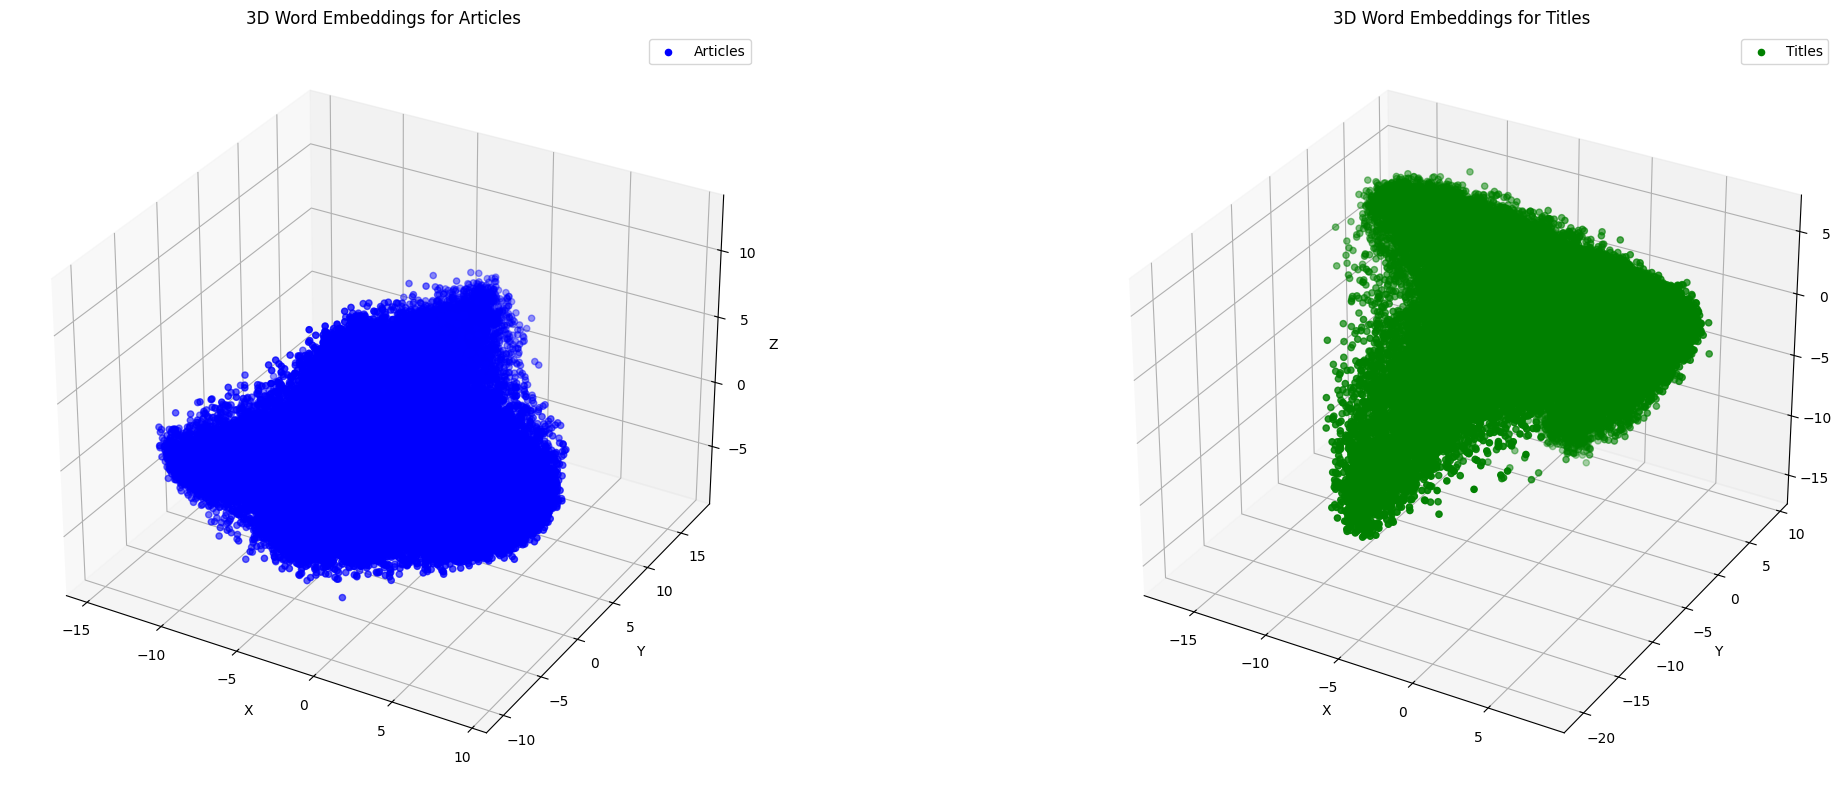

In [35]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Ensure embeddings are properly extracted
article_embeddings = np.array([np.fromstring(str(embedding).strip("[]"), sep=' ') 
                               for embedding in word_embeddings_news['article_embeddings']])
title_embeddings = np.array([np.fromstring(str(embedding).strip("[]"), sep=' ') 
                             for embedding in word_embeddings_news['title_embeddings']])

# Check dimensions before applying PCA
print(f"Article embeddings shape: {article_embeddings.shape}")
print(f"Title embeddings shape: {title_embeddings.shape}")

# Ensure PCA components don't exceed feature size
n_components = min(3, article_embeddings.shape[1])

# Reduce dimensions using PCA
article_embeddings_3d = PCA(n_components=n_components).fit_transform(article_embeddings)
title_embeddings_3d = PCA(n_components=n_components).fit_transform(title_embeddings)

# Create a 1x2 grid for the plots
fig, axs = plt.subplots(1, 2, figsize=(24, 8), subplot_kw={'projection': '3d'})

# Plot 3D embeddings for articles
axs[0].scatter(article_embeddings_3d[:, 0], article_embeddings_3d[:, 1], article_embeddings_3d[:, 2], color='blue', label='Articles')
axs[0].set_title("3D Word Embeddings for Articles")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_zlabel("Z")
axs[0].legend()

# Plot 3D embeddings for titles
axs[1].scatter(title_embeddings_3d[:, 0], title_embeddings_3d[:, 1], title_embeddings_3d[:, 2], color='green', label='Titles')
axs[1].set_title("3D Word Embeddings for Titles")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].set_zlabel("Z")
axs[1].legend()

plt.tight_layout()
plt.show()

#Plot the embeddings

In [36]:
import pandas as pd
import numpy as np
import pandas_market_calendars as mcal

# Define the NYSE calendar
nyse = mcal.get_calendar('NYSE')

# Convert 'Date' column to datetime format
word_embeddings_news['Date'] = pd.to_datetime(word_embeddings_news['Date'], errors='coerce')

# Drop rows with invalid dates
word_embeddings_news = word_embeddings_news.dropna(subset=['Date'])

# Get the minimum and maximum dates
min_date = word_embeddings_news['Date'].min()
max_date = word_embeddings_news['Date'].max()

print(f"Min Date: {min_date}, Max Date: {max_date}")

# Get valid trading days from the NYSE calendar between min and max dates
trading_days = pd.to_datetime(nyse.valid_days(start_date=min_date, end_date=max_date)).tz_localize(None)

# Extract existing news dates
news_dates = set(word_embeddings_news['Date'])

# Find missing trading days
missing_days = set(trading_days) - news_dates

# Convert missing days to DataFrame and count per year
missing_days_df = pd.DataFrame({'Missing Date': list(missing_days)})
missing_days_df['Year'] = missing_days_df['Missing Date'].dt.year
missing_counts = missing_days_df.groupby('Year').size()

# Function to safely convert string embeddings to numpy arrays
def safe_convert(embedding):
    try:
        return np.fromstring(embedding, sep=' ')
    except Exception:
        return np.array([])  # Return empty array for invalid embeddings

# Apply safe conversion
word_embeddings_news['article_embeddings'] = word_embeddings_news['article_embeddings'].apply(safe_convert)
word_embeddings_news['title_embeddings'] = word_embeddings_news['title_embeddings'].apply(safe_convert)

# Remove empty embeddings
word_embeddings_news = word_embeddings_news[word_embeddings_news['article_embeddings'].apply(lambda x: x.size > 0)]
word_embeddings_news = word_embeddings_news[word_embeddings_news['title_embeddings'].apply(lambda x: x.size > 0)]

# Convert to numpy arrays
article_embeddings = np.stack(word_embeddings_news['article_embeddings'].values)
title_embeddings = np.stack(word_embeddings_news['title_embeddings'].values)

# Print results
print("Missing trading days per year:")
print(missing_counts)

Min Date: 2016-01-01 00:00:00, Max Date: 2020-04-01 00:00:00


C:\Users\argam\AppData\Local\Temp\ipykernel_17332\2538545553.py:37: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  return np.fromstring(embedding, sep=' ')


KeyError: 'article_embeddings'

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ast  

article_embeddings = np.array([np.fromstring(embedding, sep=' ') for embedding in word_embeddings_news['article_embeddings']])
title_embeddings = np.array([np.fromstring(embedding, sep=' ') for embedding in word_embeddings_news['title_embeddings']])

# To safely convert string representations of lists to arrays
print(type(word_embeddings_news['article_embeddings'].iloc[0]))
print(word_embeddings_news['article_embeddings'].iloc[0])

# Convert stored string embeddings to numerical arrays
article_embeddings = np.array([ast.literal_eval(embedding) for embedding in word_embeddings_news['article_embeddings']])
title_embeddings = np.array([ast.literal_eval(embedding) for embedding in word_embeddings_news['title_embeddings']])

# Reduce dimensions using PCA
article_embeddings_3d = PCA(n_components=3).fit_transform(article_embeddings)
title_embeddings_3d = PCA(n_components=3).fit_transform(title_embeddings)

# Create a 1x2 grid for the plots
fig, axs = plt.subplots(1, 2, figsize=(24, 8), subplot_kw={'projection': '3d'})

# Plot 3D embeddings for articles
axs[0].scatter(article_embeddings_3d[:, 0], article_embeddings_3d[:, 1], article_embeddings_3d[:, 2], color='blue', label='Articles')
axs[0].set_title("3D Word Embeddings for Articles")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_zlabel("Z")
axs[0].legend()

# Plot 3D embeddings for titles
axs[1].scatter(title_embeddings_3d[:, 0], title_embeddings_3d[:, 1], title_embeddings_3d[:, 2], color='green', label='Titles')
axs[1].set_title("3D Word Embeddings for Titles")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].set_zlabel("Z")
axs[1].legend()

plt.tight_layout()
plt.show()

KeyError: 'article_embeddings'

#FinBERT model to calculate sentiment scores

In [ ]:
import numpy as np
import pandas as pd
import torch
import gc
from transformers import BertTokenizer, BertForSequenceClassification

# **Check for GPU availability**
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using device: {device}")

# **Load FinBERT model and tokenizer**
tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone").to(device)
model.eval()  # Set model to evaluation mode

def calculate_sentiment_with_finbert(texts, batch_size=32):
    """Processes a batch of texts using FinBERT and returns sentiment scores."""
    scores = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        
        # Tokenize inputs
        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=512
        ).to(device)

        # **Inference without gradient calculation**
        with torch.no_grad():
            outputs = model(**inputs)
            sentiments = torch.nn.functional.softmax(outputs.logits, dim=-1)
            sentiment_scores = sentiments[:, 1].cpu().tolist()  # Extract positive sentiment score
            scores.extend(sentiment_scores)

    return scores

✅ Using device: cpu


# Calculate sentiment scores for each DataFrame


In [ ]:
# **File paths for input and output**
file_paths = {
    "pos": "C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/pos_filtered_news_befor_santiment.csv",
    "bigrams": "C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/ngrams_filtered_news_befor_santiment.csv",
    "word_embeddings": "C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/filtered_news_with_finbert_embeddings.csv"
}

output_paths = {
    name: f"C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/{name}_news_with_sentiment.csv"
    for name in file_paths
}
if IMPORT_FILES:
    for name in names:
        news_dataframes[name] = pd.read_csv(output_paths[name],low_memory=False)
else:
    # **Chunk size for processing**
    chunk_size = 10_000

    # **Process each DataFrame in chunks**
    for name, input_path in file_paths.items():
        output_path = output_paths[name]
        
        print(f"✅ Processing '{name}' dataset...")

        # Read and process the file in chunks
        for chunk_index, chunk in enumerate(pd.read_csv(input_path, chunksize=chunk_size, low_memory=False)):
            print(f"🔹 Processing chunk {chunk_index + 1} for '{name}' dataset...")

            # Drop NaN rows and remove unwanted columns
            chunk = chunk.dropna().loc[:, ~chunk.columns.str.contains('^Unnamed')]

            try:
                # Compute sentiment scores for 'article' and 'title'
                chunk['article_score'] = calculate_sentiment_with_finbert(chunk['article'].tolist(), batch_size=128)
                chunk['title_score'] = calculate_sentiment_with_finbert(chunk['title'].tolist(), batch_size=128)

                # Save processed chunk (append mode to avoid overwriting)
                chunk.to_csv(output_path, mode='a', header=(chunk_index == 0), index=False)
                print(f"✅ Chunk {chunk_index + 1} processed and saved for '{name}' dataset.")

            except Exception as e:
                print(f"⚠️ Error processing chunk {chunk_index + 1} for '{name}': {str(e)}")

            # Free memory after each chunk
            gc.collect()

    # **Free GPU memory after processing all datasets**
    model.to("cpu")
    del model
    torch.cuda.empty_cache()

    print("✅ All datasets processed successfully.")

NameError: name 'news_dataframes' is not defined

Parsing for Word embeddings vectors that loads from text(csv)

In [4]:
import pandas as pd
import numpy as np
import ast
import re

def parse_embedding(s):
    """
    Convert an embedding string into a numpy array.
    If the string is well-formed (e.g., with commas), ast.literal_eval works.
    If commas are missing (e.g., "[1.0 2.0 3.0]"), we split on whitespace.
    """
    if not isinstance(s, str):
        return None
    s = s.strip()
    if s.startswith('[') and s.endswith(']'):
        try:
            # First try the literal_eval (works if commas are present)
            return np.array(ast.literal_eval(s), dtype=np.float32)
        except Exception:
            # If that fails, try splitting on whitespace
            inner = s[1:-1].strip()
            # Split by any whitespace
            parts = re.split(r'\s+', inner)
            try:
                return np.array([float(x) for x in parts], dtype=np.float32)
            except Exception:
                return None
    return None

# remove last Rows to lower dimantions 


In [5]:
import pandas as pd
import numpy as np
import ast
import re

news_dataframes = {}
names = ['pos', 'bigrams', 'word_embeddings']

ticker_mapping = {'APPLE': 'AAPL', 'AMAZON': 'AMZN', 'NETFLIX': 'NFLX'}

output_paths = {name: f"C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/{name}_news_with_sentiment.csv" for name in names}

for name in names:
    print(f"Processing {name}...")
    
    # Load data
    df = pd.read_csv(output_paths[name], low_memory=False)
    
    # Convert article_score and title_score to float32 if available
    for col in ['article_score', 'title_score']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype(np.float32)
    
    # Drop unnecessary columns and rows with missing data
    df.drop(columns=['month', 'day', 'title', 'article'], errors='ignore', inplace=True)
    df.dropna(inplace=True)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    
    # Convert Date column to datetime
    df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True, errors='coerce')
    df.dropna(subset=['Date'], inplace=True)
    
    # Standardize Tickers
    df['Ticker'] = df['Ticker'].str.strip().str.upper().replace(ticker_mapping)
    
    # --- If WE dataframe, parse embeddings for all rows ---
    if name == 'word_embeddings':
        for col in ['article_embeddings', 'title_embeddings']:
            if col in df.columns:
                df[col] = df[col].apply(parse_embedding)
    
    # --- Aggregate GENERAL rows from the original df ---
    general_df = df[df['Ticker'] == 'GENERAL'].copy().reset_index(drop=True)
    
    # For scores aggregation (applies to all dfs)
    general_scores = general_df.groupby('Date', as_index=False).agg({
        'article_score': 'mean',
        'title_score': 'mean'
    }).rename(columns={
        'article_score': 'mean_general_article_score',
        'title_score': 'mean_general_title_score'
    })
    
    # For word embeddings, also aggregate embeddings from GENERAL rows
    if name == 'word_embeddings':
        # Remove any rows where embeddings could not be parsed
        general_df = general_df.dropna(subset=['article_embeddings', 'title_embeddings'])
        
        # Group by Date to compute mean embeddings
        general_embeddings = general_df.groupby('Date', as_index=False).agg({
            'article_embeddings': lambda x: np.mean(np.vstack(x), axis=0),
            'title_embeddings': lambda x: np.mean(np.vstack(x), axis=0)
        })
        # Rename columns for clarity
        general_embeddings.rename(columns={
            'article_embeddings': 'mean_general_article_embeddings',
            'title_embeddings': 'mean_general_title_embeddings'
        }, inplace=True)
        
        # Merge the embeddings with the general scores
        general_agg = general_scores.merge(general_embeddings, on='Date', how='left')
    else:
        general_agg = general_scores.copy()
    
    # --- Remove GENERAL rows from the main dataframe ---
    df = df[df['Ticker'] != 'GENERAL'].copy()
    
    # --- Merge aggregated GENERAL features into the main df ---
    df = df.merge(general_agg, on='Date', how='left')
    
    # Fill missing scores with 0
    df['mean_general_article_score'] = df['mean_general_article_score'].fillna(0).astype(np.float32)
    df['mean_general_title_score'] = df['mean_general_title_score'].fillna(0).astype(np.float32)
    
    # For WE df, also fill missing embeddings with zeros of proper shape.
    if name == 'word_embeddings':
        # Determine embedding dimension:
        emb_dim = None
        if 'mean_general_article_embeddings' in df.columns:
            sample_series = df['mean_general_article_embeddings'].dropna()
            if not sample_series.empty:
                sample = sample_series.iloc[0]
                emb_dim = len(sample) if isinstance(sample, np.ndarray) else None
        if emb_dim is None and 'article_embeddings' in df.columns:
            sample = df['article_embeddings'].iloc[0]
            if isinstance(sample, str):
                sample = parse_embedding(sample)
            emb_dim = len(sample) if sample is not None else 300  # default fallback
        if emb_dim is None:
            emb_dim = 300
        
        # Fill missing aggregated embeddings with zeros
        for col in ['mean_general_article_embeddings', 'mean_general_title_embeddings']:
            if col in df.columns:
                df[col] = df[col].apply(lambda x: x if isinstance(x, np.ndarray) else np.zeros(emb_dim, dtype=np.float32))
    
    news_dataframes[name] = df
    
    print(df.describe(include='all'))
    print("-" * 50)

Processing pos...
                                 Date Ticker  article_score   title_score  \
count                           56171  56171   5.617100e+04  5.617100e+04   
unique                            NaN      3            NaN           NaN   
top                               NaN   AMZN            NaN           NaN   
freq                              NaN  24258            NaN           NaN   
mean    2018-03-23 07:54:05.197699840    NaN   4.034433e-03  3.438787e-03   
min               2016-01-01 00:00:00    NaN   6.052462e-07  7.931056e-07   
25%               2017-03-04 00:00:00    NaN   7.372523e-06  1.861340e-05   
50%               2018-04-11 00:00:00    NaN   1.332102e-05  4.169398e-05   
75%               2019-04-25 00:00:00    NaN   2.700800e-05  9.760138e-05   
max               2020-04-01 00:00:00    NaN   9.999988e-01  9.999982e-01   
std                               NaN    NaN   5.533271e-02  5.133732e-02   

        mean_general_article_score  mean_general_title_sc

c:\Users\argam\anaconda3\envs\FinTrendLSTM\lib\site-packages\pandas\core\indexes\base.py:5360: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self._engine
c:\Users\argam\anaconda3\envs\FinTrendLSTM\lib\site-packages\pandas\core\indexes\base.py:5360: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self._engine
c:\Users\argam\anaconda3\envs\FinTrendLSTM\lib\site-packages\pandas\core\indexes\base.py:5360: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self._engine


                                 Date Ticker  \
count                           55723  55723   
unique                            NaN      3   
top                               NaN   AMZN   
freq                              NaN  24030   
mean    2018-03-23 05:32:44.581950208    NaN   
min               2016-01-01 00:00:00    NaN   
25%               2017-03-03 00:00:00    NaN   
50%               2018-04-11 00:00:00    NaN   
75%               2019-04-25 00:00:00    NaN   
max               2020-04-01 00:00:00    NaN   
std                               NaN    NaN   

                                       article_embeddings  \
count                                               55723   
unique                                              55723   
top     [0.118718304, 0.3063625, -0.6674092, 1.4475749...   
freq                                                    1   
mean                                                  NaN   
min                                                   NaN

c:\Users\argam\anaconda3\envs\FinTrendLSTM\lib\site-packages\pandas\core\indexes\base.py:5360: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self._engine


#Financial data

In [6]:
import os
all_data_file_path = "C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/all_stocks_data.csv"

if IMPORT_FILES:
    # Load the stock data
    financial_data = pd.read_csv(all_data_file_path)
    
    # Convert Date column to datetime
    financial_data['Date'] = pd.to_datetime(financial_data['Date'])
    
    # Standardize Tickers (trim spaces, convert to uppercase)
    financial_data['Ticker'] = financial_data['Ticker'].str.strip().str.upper()

else:
    # Define the list of stock symbols and date range
    stocks = ["AAPL", "AMZN", "NFLX"]
    start_date = "2016-01-01"
    end_date = "2020-12-31"
    stock_data_path = "C:/Users/argam/Documents/GitHub/FinTrendLSTM/data"

    # Add a directory to save the dataframes
    data_frames = {}

    # Ensure the save path exist
    os.makedirs(stock_data_path, exist_ok=True)

    # Loop through the stocks and download the data
    for stock in stocks:
        data = yf.download(stock, start=start_date, end=end_date)

        # Reset the index to make Date a column
        data.reset_index(inplace=True)

        # Add the Ticker column
        data['Ticker'] = stock   

        #print all the unfolded lyres of the dataframe loop ovrer data and unfold it
        data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data.columns]

        # rename the columns bu rmoving the everythign after the underscore including the underscore
        data.columns = [col.split("_")[0] for col in data.columns]

        # Keep only necessary columns
        data = data[["Ticker", "Date", "Open", "Close", "High", "Low", "Volume"]]

        # Add the data to the dictionary
        data_frames[stock] = data

        # Save the data to a CSV file
        file_path = os.path.join(stock_data_path, f"{stock}_stock_data.csv")
        data.to_csv(file_path, index=False)
        
    # combine all the dataframes into a single dataframe
    for stock, data in data_frames.items():
        if stock == stocks[0]:
            all_data = data
        else:
            all_data = pd.concat([all_data, data], ignore_index=True, axis=0)

    # Save the combined data to a CSV file
    all_data.to_csv(all_data_file_path, index=False)



In [7]:
import pandas as pd

# Function to calculate RSI
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)  

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

# Function to calculate SMA
def calculate_sma(data, window=14):
    return data.rolling(window=window, min_periods=1).mean()

# Function to calculate Stochastic Oscillator %K
def calculate_stochastic_oscillator(data, window=14):
    low_min = data['Low'].rolling(window=window, min_periods=1).min()
    high_max = data['High'].rolling(window=window, min_periods=1).max()
    stochastic_k = 100 * (data['Close'] - low_min) / (high_max - low_min)
    return stochastic_k

# Ensure each financial metric is calculated per stock ticker
financial_data['RSI'] = financial_data.groupby('Ticker')['Close'].transform(calculate_rsi)
financial_data['SMA'] = financial_data.groupby('Ticker')['Close'].transform(calculate_sma)

# Fix for Stochastic Oscillator %K to return a Series, avoiding the ValueError
financial_data['%K'] = financial_data.groupby('Ticker', group_keys=False)['Close'].transform(
    lambda x: calculate_stochastic_oscillator(financial_data.loc[x.index], window=14)
)

# ✅ **Fix: Correct `Class` Calculation for Regression**
financial_data['Class'] =  financial_data['Close'] - financial_data['Open']

# ✅ **Fix: Normalize Prices**
financial_data['Close'] = financial_data.groupby('Ticker')['Close'].transform(lambda x: (x - x.mean()) / x.std())
financial_data['Open'] = financial_data.groupby('Ticker')['Open'].transform(lambda x: (x - x.mean()) / x.std())
financial_data['High'] = financial_data.groupby('Ticker')['High'].transform(lambda x: (x - x.mean()) / x.std())
financial_data['Low'] = financial_data.groupby('Ticker')['Low'].transform(lambda x: (x - x.mean()) / x.std())

# Debugging: Print min/max values
print(financial_data[['Close', 'Class']].describe())

# Display the first few rows
for col in financial_data.columns:
    print(f'{col} :', financial_data[col].min(), financial_data[col].max())

              Close        Class
count  3.774000e+03  3774.000000
mean   7.530925e-17     0.042013
std    9.997349e-01     3.965401
min   -1.456981e+00   -42.479980
25%   -8.684492e-01    -0.582996
50%   -6.745292e-02     0.023996
75%    5.324786e-01     0.666679
max    3.265605e+00    55.030029
Ticker : AAPL NFLX
Date : 2016-01-04 00:00:00 2020-12-30 00:00:00
Open : -1.4738189148522423 3.3179012392395575
Close : -1.4569807843961589 3.265605330664182
High : -1.4496758524740394 3.2744137826463975
Low : -1.47138237369525 3.2528964121925474
Volume : 1144000 533478800
RSI : 0.0 96.20447525782778
SMA : 21.277334349496023 530.5142822265625
%K : 0.0 100.0
Class : -42.47998046875 55.030029296875


In [8]:
# Normalize function to scale 0 to 1
def normalize_zero(column):
    return (column - column.min()) / (column.max() - column.min())

# Normalize function to scale -1 to 1
def normalize_minus_one(column):
    return 2 * ((column - column.min()) / (column.max() - column.min())) - 1

# Columns that still need normalization
zero_normalized_columns = ['Volume', 'RSI', 'SMA', '%K']
minus_one_normalized_columns = ['Class']

# Apply normalization
for col in zero_normalized_columns:
    financial_data[col] = normalize_zero(financial_data[col])

for col in minus_one_normalized_columns:
    financial_data[col] = normalize_minus_one(financial_data[col])

# Convert columns to float32 for memory efficiency
for col in financial_data.columns:
    if col not in ['Date', 'Ticker']:
        financial_data[col] = financial_data[col].astype(np.float32)

# Debug print
print(financial_data[['Volume', 'RSI', 'SMA', '%K', 'Class']].describe())

            Volume          RSI          SMA           %K        Class
count  3774.000000  3771.000000  3774.000000  3774.000000  3774.000000
mean      0.142606     0.587927     0.217590     0.612324    -0.127844
std       0.126602     0.178183     0.247541     0.295650     0.081333
min       0.000000     0.000000     0.000000     0.000000    -1.000000
25%       0.018515     0.463059     0.040581     0.360667    -0.140663
50%       0.132042     0.596841     0.130074     0.680343    -0.128213
75%       0.210005     0.721643     0.268836     0.878127    -0.115031
max       1.000000     1.000000     1.000000     1.000000     1.000000


C:\Users\argam\AppData\Local\Temp\ipykernel_25492\942090174.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=financial_data, x='Ticker', y=col, ax=ax, palette=palette)
C:\Users\argam\AppData\Local\Temp\ipykernel_25492\942090174.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=financial_data, x='Ticker', y=col, ax=ax, palette=palette)
C:\Users\argam\AppData\Local\Temp\ipykernel_25492\942090174.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=financial_data, x='Ticker', y=col, ax=ax, palette=palette)
C:\User

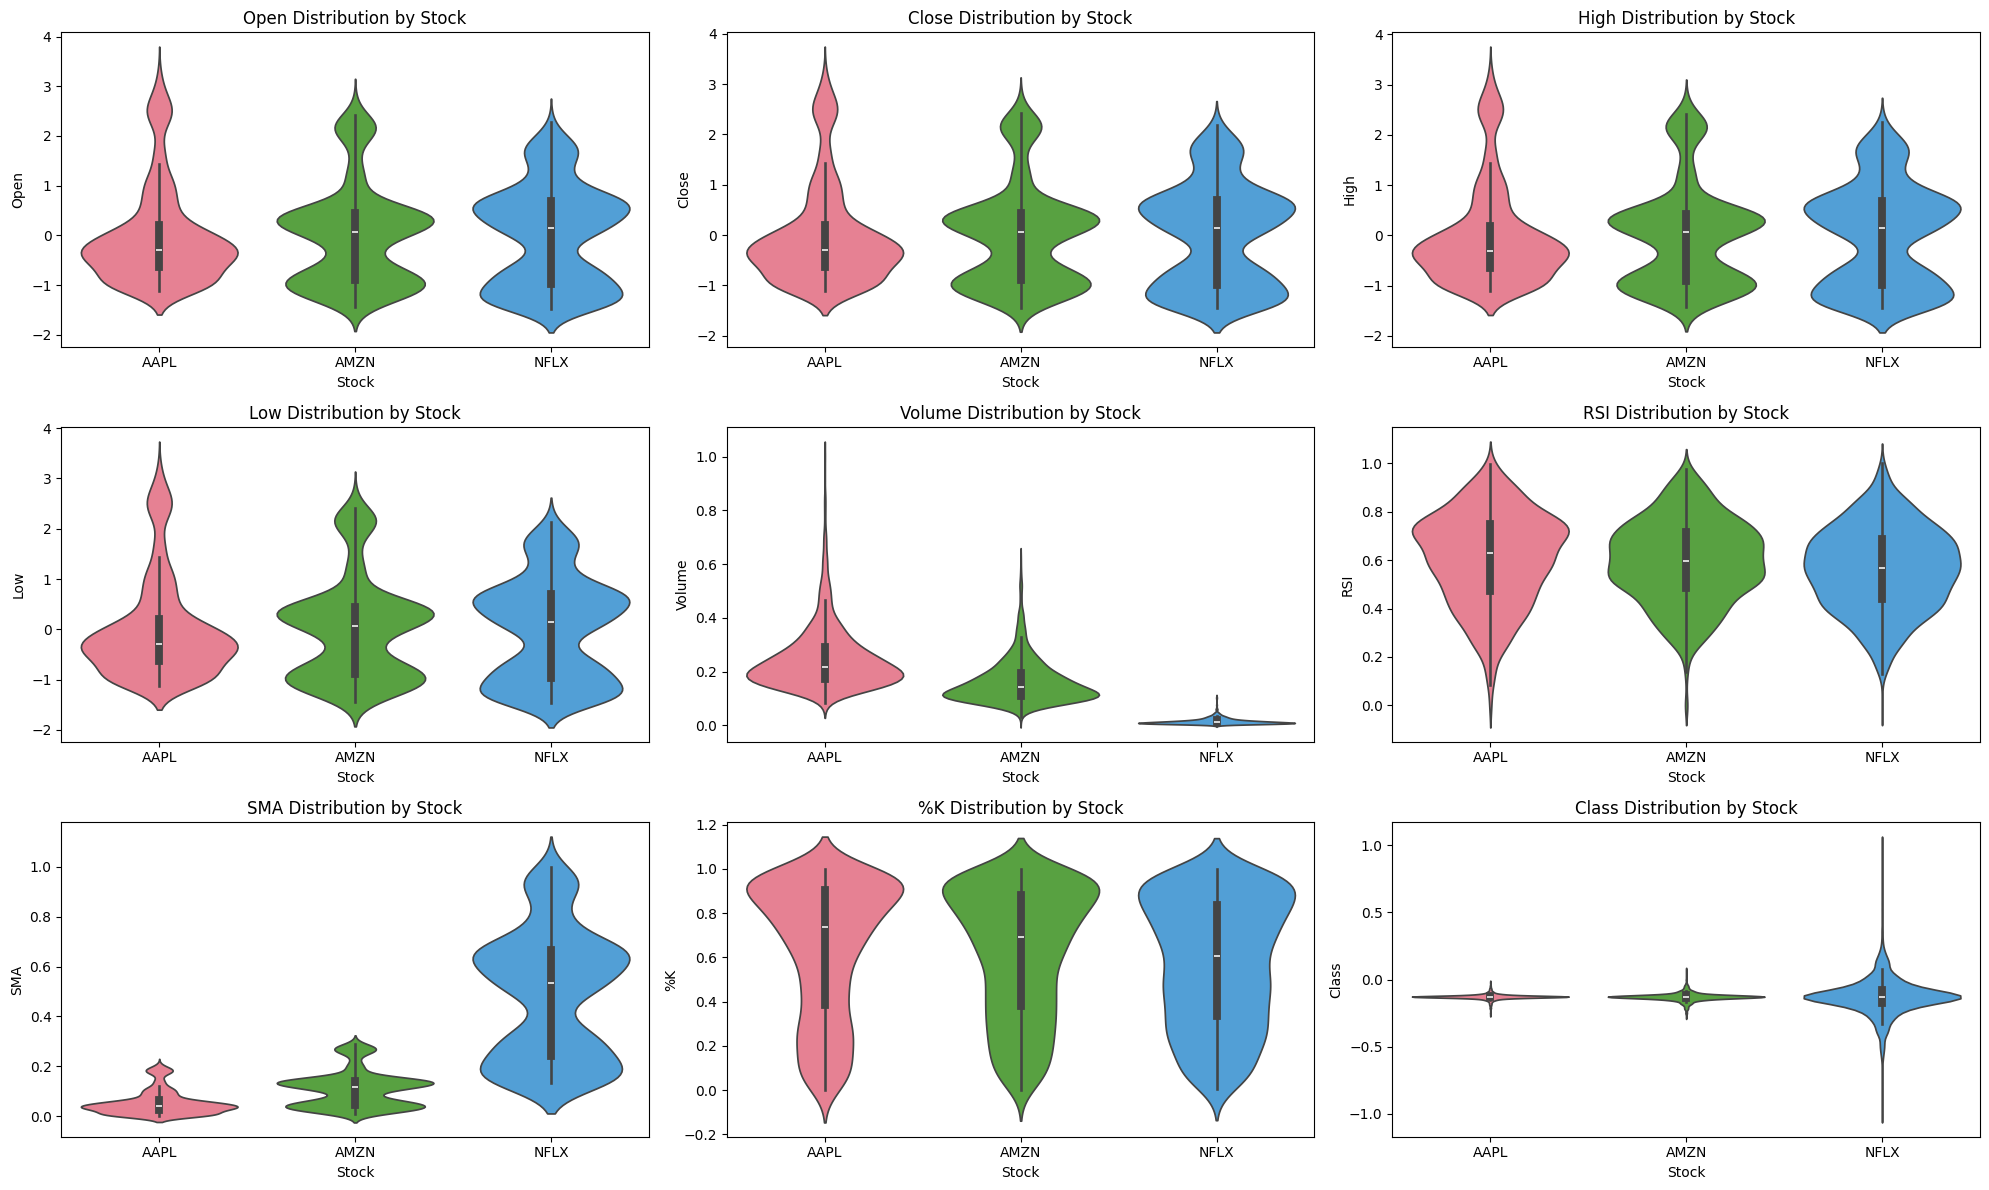

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Columns to plot (excluding Date and Ticker)
columns_to_plot = [col for col in financial_data.columns if col not in ['Date', 'Ticker']]
num_columns = 3  # 3 plots per row
num_rows = math.ceil(len(columns_to_plot) / num_columns)  # Auto-adjust rows

# Get unique tickers and assign each a color
unique_tickers = financial_data['Ticker'].unique()
palette = sns.color_palette("husl", len(unique_tickers))  # Generate unique colors

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(20, 4 * num_rows))
axes = axes.flatten()  # Flatten for easier indexing

# Generate violin plots
for i, col in enumerate(columns_to_plot):
    ax = axes[i]
    sns.violinplot(data=financial_data, x='Ticker', y=col, ax=ax, palette=palette)
    ax.set_title(f"{col} Distribution by Stock")
    ax.set_xlabel("Stock")
    ax.set_ylabel(col)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [10]:
# Combain the news and financial data
# First we will get one line per date per stock by taking the mean of the article and title scores
# Then we will merge the news and financial data on the date and stock ticker keeping only the financial data and 
# article and title scores
# we will save the new data frames in a dictionary so we will have a unique data frame for each preprocessed strategy
# at the moment we will not use the word embeddings as it is not clear how to combine the data
from sklearn.decomposition import PCA
import os

final_dataframes = {}

for name, df in news_dataframes.items():
    # Merge general news mean values into the main dataset
    df = df.merge(financial_data, on=['Date', 'Ticker'], how='left')

    #Save the data frame as a csv file
    # output_file_path = f"C:/Users/argam/Documents/GitHub/FinTrendLSTM/data/{name}_news_with_financial_data.csv"
    # df.to_csv(output_file_path, index=False)
    final_dataframes[name] = df


In [11]:

# for name, data in final_dataframes.items():
#     #print the columns of the data and there types
#     print (f'{name} data columns and types')
#     for col in data.columns:
#         print(f'{col} : {data[col].dtype}')
#         if name == 'word_embeddings_final_data' and col in ['article_embeddings', 'title_embeddings']:
#             # Print the dimensions of the embeddings
#             print(f"{col} shape: {data[col].apply(lambda x: x.shape).iloc[0]}")
#     print(data.shape[0], '\n')

In [12]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.utils.class_weight import compute_class_weight

# # Extract features and labels
# def prepare_data(df, scale=True):
#     df = df.copy()
#     df = df.drop(columns=['Ticker', 'Date'], errors='ignore')  # Remove non-numeric columns
#     df = df.fillna(0)  # Replace NaNs with 0
#     df['Class'] = df['Class'].astype(float)  # Ensure 'Class' is numeric
    
#     X = df.drop(columns=['Class']).values  # Convert DataFrame to NumPy array
#     y = df['Class'].values

#     if scale:
#         scaler = MinMaxScaler()
#         X = scaler.fit_transform(X)
    
#     X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape to 3D for LSTM
#     return train_test_split(X, y, test_size=0.2, random_state=42)

# # Special case for word embeddings (no MinMax scaling)
# def prepare_embedding_data(df):
#     df = df.copy()
#     df = df.fillna(0)  # Replace NaNs with 0
#     df['Class'] = df['Class'].astype(float)  # Ensure 'Class' is numeric
    
#     df['article_embeddings'] = df['article_embeddings'].apply(lambda x: np.array(x) if isinstance(x, list) else x)
#     df['title_embeddings'] = df['title_embeddings'].apply(lambda x: np.array(x) if isinstance(x, list) else x)
    
#     X = np.hstack([np.stack(df['article_embeddings'].values), np.stack(df['title_embeddings'].values)])
#     y = df['Class'].values
    
#     X = X.reshape((X.shape[0], 1, X.shape[1]))  # Reshape to 3D for LSTM
#     return train_test_split(X, y, test_size=0.2, random_state=42)

# # Load preprocessed data
# X_train_pos, X_test_pos, y_train_pos, y_test_pos = prepare_data(pos_final_data)
# X_train_bigrams, X_test_bigrams, y_train_bigrams, y_test_bigrams = prepare_data(bigrams_final_data)
# X_train_emb, X_test_emb, y_train_emb, y_test_emb = prepare_embedding_data(word_embeddings_final_data)

# # Compute class weights
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train_pos), y=y_train_pos)
# class_weight_dict = dict(enumerate(class_weights))

# # Define LSTM model for POS/Bigrams
# def build_lstm_model(input_shape, lstm_units=128, dropout_rate=0.3):
#     model = Sequential([
#         LSTM(units=lstm_units, return_sequences=True, activation='tanh', input_shape=input_shape),
#         BatchNormalization(),
#         Dropout(rate=dropout_rate),
#         LSTM(units=lstm_units, activation='tanh'),
#         BatchNormalization(),
#         Dropout(rate=dropout_rate),
#         Dense(units=1, activation='sigmoid')
#     ])
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# # Define LSTM model for Word Embeddings
# def build_lstm_embedding_model(input_shape, lstm_units=128, dropout_rate=0.3):
#     model = Sequential([
#         LSTM(units=lstm_units, return_sequences=True, activation='tanh', input_shape=(input_shape[0], input_shape[1])),
#         BatchNormalization(),
#         Dropout(rate=dropout_rate),
#         LSTM(units=lstm_units, activation='tanh'),
#         BatchNormalization(),
#         Dropout(rate=dropout_rate),
#         Dense(units=1, activation='sigmoid')
#     ])
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# # Function to train model with logging
# def train_model(model, X_train, y_train, X_test, y_test, name, batch_size=64, epochs=20):
#     print(f'Training {name} model...')
#     history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
#                         validation_data=(X_test, y_test), 
#                         class_weight=class_weight_dict, verbose=2)
#     return history

# # Train and evaluate POS model
# pos_input_shape = (X_train_pos.shape[1], 1)
# model_pos = build_lstm_model(pos_input_shape)
# history_pos = train_model(model_pos, X_train_pos, y_train_pos, X_test_pos, y_test_pos, "POS")

# # Train and evaluate Bigrams model
# bigrams_input_shape = (X_train_bigrams.shape[1], 1)
# model_bigrams = build_lstm_model(bigrams_input_shape)
# history_bigrams = train_model(model_bigrams, X_train_bigrams, y_train_bigrams, X_test_bigrams, y_test_bigrams, "Bigrams")

# # Train and evaluate Word Embeddings model
# emb_input_shape = (X_train_emb.shape[1], X_train_emb.shape[2])
# model_emb = build_lstm_embedding_model(emb_input_shape)
# history_emb = train_model(model_emb, X_train_emb, y_train_emb, X_test_emb, y_test_emb, "Word Embeddings")

# # Evaluate models
# def evaluate_model(model, X_test, y_test, name):
#     loss, accuracy = model.evaluate(X_test, y_test)
#     print(f'{name} Model Test Accuracy: {accuracy:.4f}')

# evaluate_model(model_pos, X_test_pos, y_test_pos, "POS")
# evaluate_model(model_bigrams, X_test_bigrams, y_test_bigrams, "Bigrams")
# evaluate_model(model_emb, X_test_emb, y_test_emb, "Word Embeddings")


In [13]:
# import gc
# import pandas as pd

# max_sample = 1 if TEST else 20

# before = len(filtered_news)
    
# # Count news articles per stock per day
# news_counts = filtered_news.groupby(['Date', 'Ticker']).size().reset_index(name='count')

# # Find the minimum news count on any day across all stocks
# min_news_per_day = news_counts['count'].min()
# min_news_date = news_counts[news_counts['count'] == min_news_per_day]['Date'].unique()

# # Count how many stock-days have more than this minimum
# above_min_count = (news_counts['count'] > min_news_per_day).sum()

# # Apply filtering: randomly sample up to max_sample articles per date per ticker
# filtered_news = (
#    filtered_news.groupby(['Date', 'Ticker'])
#    .apply(lambda x: x.sample(n=min(len(x), max_sample), random_state=42))
#    .reset_index(drop=True))

# # Free memory
# gc.collect()

# after = len(filtered_news)

# print(f"We have deleted {before - after} rows and we currently have {after} rows in our DataFrame")

In [14]:
import numpy as np

ticker_map = {'AAPL': '1', 'AMZN': '2', 'NFLX': '3'}

for name, data in final_dataframes.items():
    data['Ticker'] = data['Ticker'].replace(ticker_map)
    data['Ticker'] = data['Ticker'].astype('float32')
    data.fillna(0, inplace=True)
    
    
    for col in data.columns:
        if "embeddings" in col:
            sample = data[col].iloc[0]  # Get first element
            if isinstance(sample, np.ndarray):
                print(f"{col} {data[col].dtype}: NumPy array with shape {sample.shape}")
            else:
                print(f"{col} {data[col].dtype}: ❌ NOT NumPy (type: {type(sample)}")
        else:
            print(f"{col} : {data[col].dtype}")
    
    print("\n")  # Add tab spacing per data frame

f_pos_news = final_dataframes['pos']
f_bigrams_news = final_dataframes['bigrams']
f_word_embeddings_news = final_dataframes['word_embeddings']

Date : datetime64[ns]
Ticker : float32
article_score : float32
title_score : float32
mean_general_article_score : float32
mean_general_title_score : float32
Open : float32
Close : float32
High : float32
Low : float32
Volume : float32
RSI : float32
SMA : float32
%K : float32
Class : float32


Date : datetime64[ns]
Ticker : float32
article_score : float32
title_score : float32
mean_general_article_score : float32
mean_general_title_score : float32
Open : float32
Close : float32
High : float32
Low : float32
Volume : float32
RSI : float32
SMA : float32
%K : float32
Class : float32


Date : datetime64[ns]
Ticker : float32
article_embeddings object: NumPy array with shape (768,)
title_embeddings object: NumPy array with shape (768,)
article_score : float32
title_score : float32
mean_general_article_score : float32
mean_general_title_score : float32
mean_general_article_embeddings object: NumPy array with shape (768,)
mean_general_title_embeddings object: NumPy array with shape (768,)
Open : 

WE want to build an LSTM model for stock trend prediction based on a 5-day time window where each input at time t is a vector of daily features. The model will take batches of stock data, process them with an embedding layer, and predict whether the trend is up (1) or down (0).

pos date range: 2016-01-01 00:00:00 to 2020-04-01 00:00:00
Number of days with zero articles for at least one ticker: 7
1.0 - Days below Avg: 314, Days below Median: 382, Min: 1, Max: 20
2.0 - Days below Avg: 126, Days below Median: 126, Min: 1, Max: 20
3.0 - Days below Avg: 578, Days below Median: 499, Min: 0, Max: 20


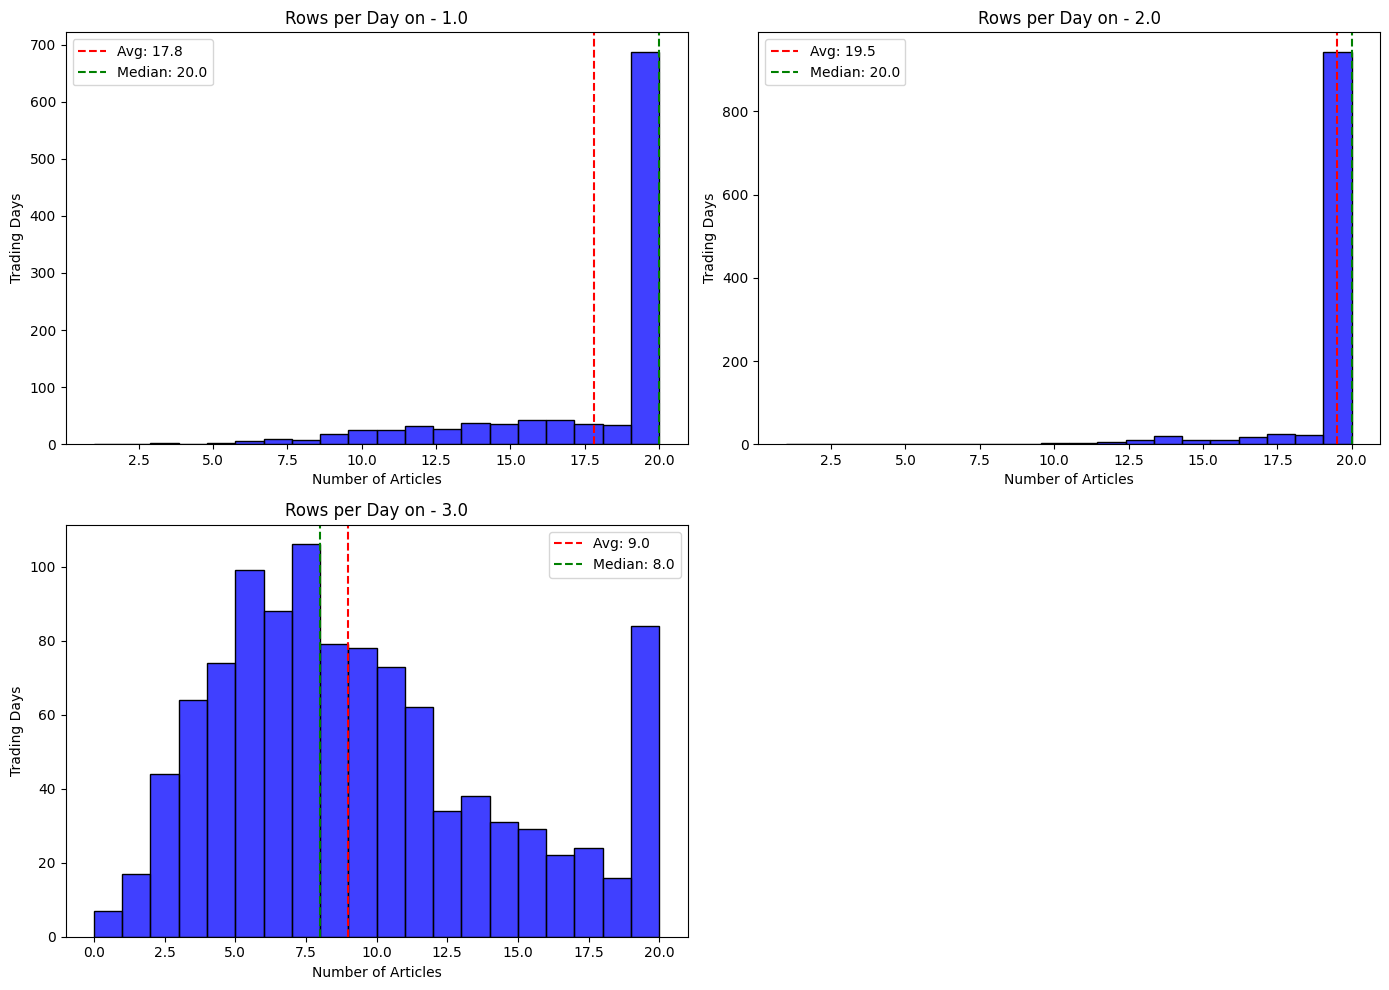

56171
bigrams date range: 2016-01-01 00:00:00 to 2020-04-01 00:00:00
Number of days with zero articles for at least one ticker: 7
1.0 - Days below Avg: 314, Days below Median: 382, Min: 1, Max: 20
2.0 - Days below Avg: 126, Days below Median: 126, Min: 1, Max: 20
3.0 - Days below Avg: 578, Days below Median: 499, Min: 0, Max: 20


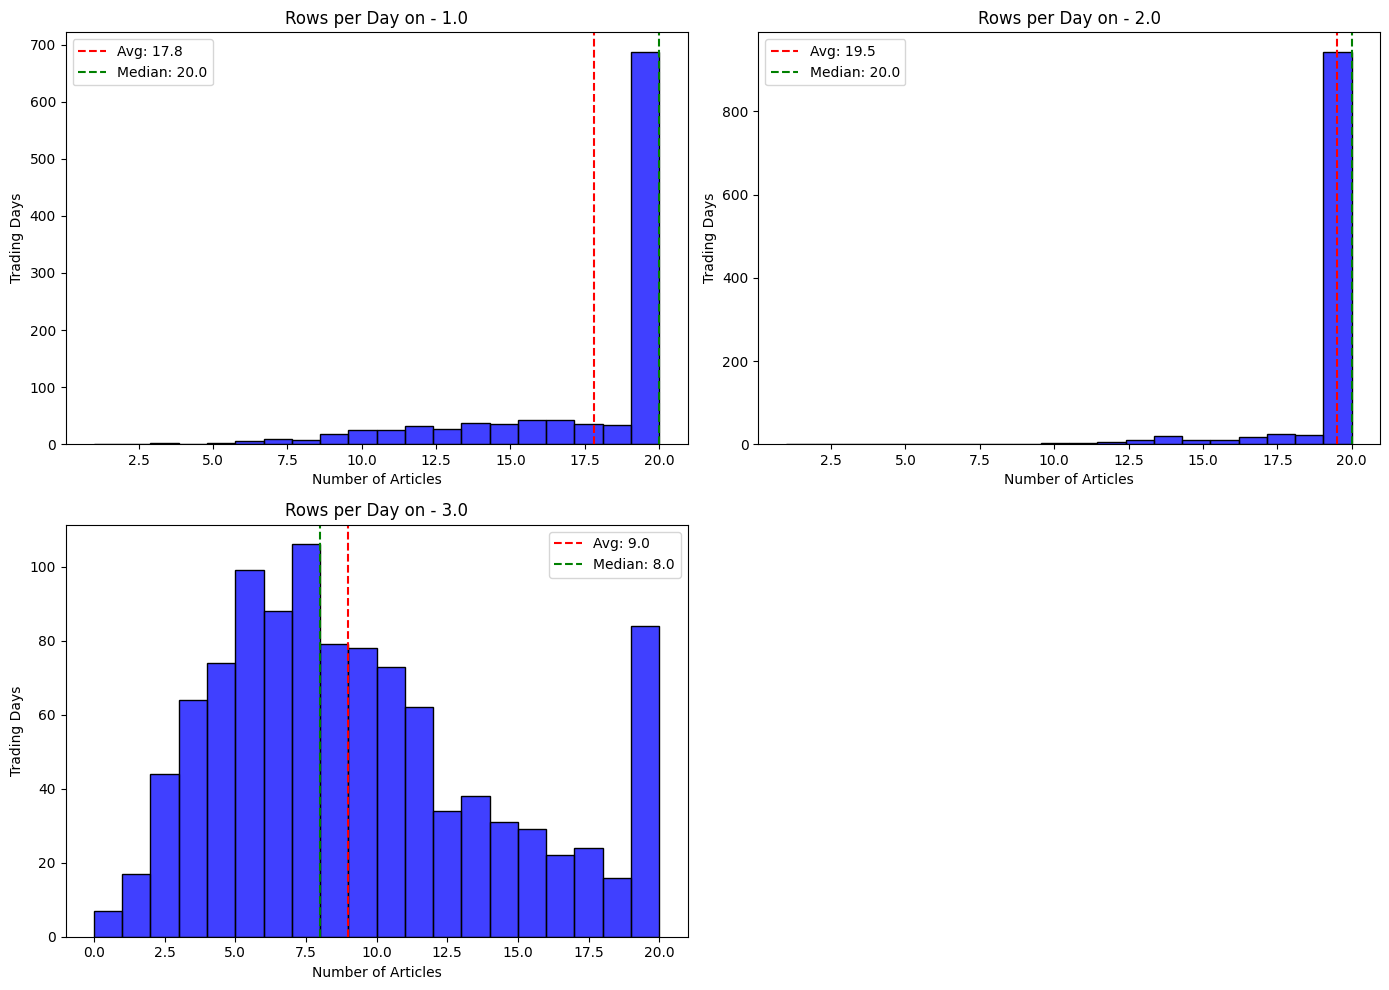

56171
word_embeddings date range: 2016-01-01 00:00:00 to 2020-04-01 00:00:00
Number of days with zero articles for at least one ticker: 7
1.0 - Days below Avg: 318, Days below Median: 459, Min: 1, Max: 20
2.0 - Days below Avg: 290, Days below Median: 290, Min: 1, Max: 20
3.0 - Days below Avg: 582, Days below Median: 505, Min: 0, Max: 20


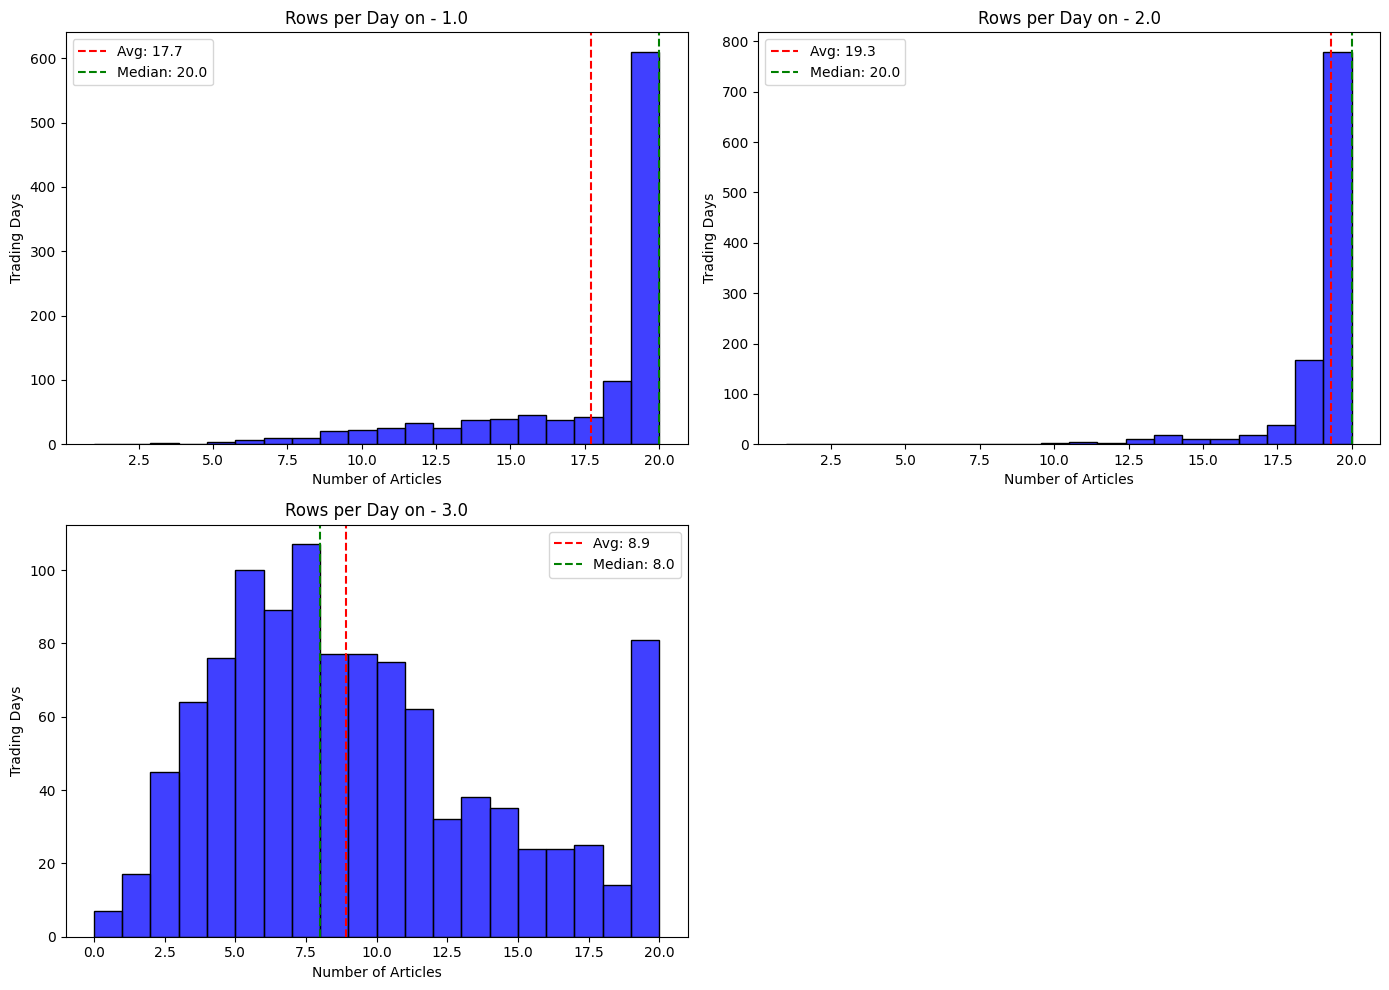

55723


In [15]:
import pandas as pd
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

for name, data in final_dataframes.items():
    # Define the NYSE calendar
    nyse = mcal.get_calendar('NYSE')

    # Convert 'Date' column to datetime format
    data['Date'] = pd.to_datetime(data['Date'])

    # Define date range
    start_date = data['Date'].min()
    end_date = data['Date'].max()

    # Check if any rows in 'data' are outside the valid date range
    print(f"{name} date range: {data['Date'].min()} to {data['Date'].max()}")

    # Group by 'Date' and 'Ticker' to count articles per day per stock
    news_counts = data.groupby(['Date', 'Ticker']).size().unstack(fill_value=0)

    # Get valid trading days from the NYSE calendar
    trading_days = pd.to_datetime(nyse.valid_days(start_date=start_date, end_date=end_date))

    # Remove any timezone information from trading_days to match data dates
    trading_days = trading_days.tz_localize(None)

    # Reindex to ensure all trading days are present (fill missing with 0)
    news_counts = news_counts.reindex(trading_days, fill_value=0)

    # Remove "noisy" data: Set values greater than 150 to NaN (or 0)
    news_counts[news_counts > 150] = 0

    # Count the number of days with 0 articles for at least one ticker
    days_with_no_articles = (news_counts == 0).any(axis=1).sum()

    # Print the count of days with zero articles for at least one ticker
    print(f"Number of days with zero articles for at least one ticker: {days_with_no_articles}")

    # Get tickers
    tickers = news_counts.columns.tolist()

    # Set up subplot grid (2x2 for up to 4 tickers)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
    axes = axes.flatten()

    # Iterate over tickers and plot
    for i, ticker in enumerate(tickers[:4]):  # Ensure we only plot up to 4 tickers
        ax = axes[i]
        sns.histplot(news_counts[ticker], bins=20, kde=False, ax=ax, color='blue')
        
        # Calculate statistics
        avg = news_counts[ticker].mean()
        median = news_counts[ticker].median()
        min_articles = news_counts[ticker].min()
        max_articles = news_counts[ticker].max()
        days_below_avg = (news_counts[ticker] < avg).sum()
        days_below_median = (news_counts[ticker] < median).sum()
        
        # Plot vertical lines for average and median
        ax.axvline(avg, color='red', linestyle='--', label=f'Avg: {avg:.1f}')
        ax.axvline(median, color='green', linestyle='--', label=f'Median: {median:.1f}')
        
        # Labels and title
        ax.set_title(f"Rows per Day on - {ticker}")
        ax.set_xlabel("Number of Articles")
        ax.set_ylabel("Trading Days")
        ax.legend()
        
        # Print stats
        print(f"{ticker} - Days below Avg: {days_below_avg}, Days below Median: {days_below_median}, Min: {min_articles}, Max: {max_articles}")

    # Remove unused subplots if there are fewer than 4 tickers
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    print(len(data))


1. Goal of the Model
The primary goal of the model is to predict the stock trend on the 5th day using a 5-day window based on a dataset containing technical and sentiment-related features.
The model follows these constraints:
•	It uses historical stock data and sentiment data to learn patterns.
•	The input must be structured in a way that it can be passed into an LSTM model.
•	The output is a single value that represents the stock movement classification for the 5th day.
•	The aim is to improve on the Random Forest baseline by implementing LSTM-based deep learning.
•	The embedding layer is critical for structuring the input correctly.
________________________________________
2. Nature of the pos Data and Features
The dataset (referred to as pos) consists of stock data and computed sentiment scores. The features include:
•	Numerical features: These represent stock indicators, price movements, and sentiment analysis outputs.
•	Date column (Date): Represents the date of the stock record.
•	Stock identifier (Ticker): Specifies which stock the data belongs to.
•	Target column (Class): This is the label we are predicting, indicating stock movement.
Important properties of the dataset:
•	The number of records per stock per day varies (some stocks may have fewer than 20 rows per day).
•	The goal is to ensure that each stock-date combination has exactly 20 rows, padding if necessary.
•	The dataset needs to be split into train and test by date (not randomly).
•	Feature selection must exclude Date and Class, but all numerical columns must be included.
________________________________________
3. Input Specifications for the Model
To ensure the input meets the LSTM model’s requirements, the following constraints must be applied:
A. Data Processing and Windowing
1.	The dataset must be grouped by Ticker and Date.
2.	Each stock-date pair must have exactly 20 rows (using padding if necessary).
3.	A 5-day window must be created so that:
o	Each input sample consists of 5 consecutive days of data.
o	The model learns from 5 days of historical data to predict the 5th day's target.
4.	The dataset should be structured as:
o	5 days × 20 rows per day × number of features per row (for the LSTM).
o	20 rows per day × number of features per row (for a single LSTM cell input).
B. Embedding Layer Requirements
1.	The embedding layer should process entire daily sequences (20 rows per day) for each stock.
2.	Since some stocks have fewer than 20 rows per day, padding is required.
3.	The embedding layer should be applied before the LSTM layer so that it receives properly structured inputs.
C. Train-Test Split
1.	Data splitting should be by date rather than a percentage of total rows.
2.	Train and test datasets must be ordered correctly (i.e., no shuffled data).
3.	The train set should be based on the first 80% of unique dates, while the test set should be based on the last 20%.
4.	Within each dataset, rows must be grouped by ticker and date.
D. Batch Processing
1.	Shuffling should NOT be used in the DataLoader because:
o	The LSTM model depends on sequential patterns.
o	Data must remain temporally ordered so that time dependencies are preserved.
________________________________________
4. List of All Problems Encountered
Here is a list of the issues identified and fixed so far:
A. Data Processing Issues
1.	Incorrect dropping of Date and Class 
o	Initially, dropping Date removed the ability to track which rows belong to which day within the 5-day window.
o	Fix: Ensure Date is used to group data correctly before dropping it.
2.	Incorrect handling of missing rows 
o	Some stocks had fewer than 20 rows in the original data, but we moved all the rows to a single stock-date pair row where each row contains a feature1…20 with padding applied when necessary.
3.	Incorrect window slicing 
o	The code originally used simple slicing without ensuring 5 full days were included.
o	Fix: Implemented proper 5-day rolling windows, ensuring each input contains exactly 5 days.
B. Model Input Issues
4.	Shape mismatch errors in LSTM 
o	The LSTM was expecting 5 × number of features, but the input wasn’t formatted correctly.
o	Fix: Reshaped data properly before passing it into the model.
5.	Incorrect input to embedding layer 
o	The embedding layer was expecting sequences but was not receiving properly structured sequences.
o	Fix: Made sure that all rows for a given date are fed in correctly.
C. Train-Test Splitting Issues
6.	Incorrect train-test split logic 
o	Initially, the train-test split was done by row count, rather than date-based splitting.
o	Fix: Changed the split to be based on unique dates.
7.	Shuffling in DataLoader 
o	Shuffling was applied, which disrupted the time dependencies.
o	Fix: Disabled shuffling in both trainloader and testloader.
________________________________________
5. Model Evaluation and Parameter Tuning
After training, the model should be evaluated using a confusion matrix and other relevant metrics.
A. Performance Metrics
•	Mean Squared Error (MSE): Measures prediction error but is not ideal for classification.
•	Confusion Matrix: Displays true positives, false positives, false negatives, and true negatives.
•	Precision, Recall, F1-score, and Accuracy: Critical for evaluating classification performance.
B. Confusion Matrix Plot
•	The confusion matrix should be plotted after testing the model.
•	sklearn.metrics.confusion_matrix should be used.
•	seaborn.heatmap can visualize the matrix.
C. Hyperparameter Tuning
Key hyperparameters that may need adjustment:
•	Learning rate (lr=0.001 initially) → Experiment with values like 0.0005, 0.0001
•	Hidden layer size (hidden_size=64 initially) → Try values like 128, 256
•	Batch size (batch_size=32 initially) → Adjust to 16 or 64 to see impact
•	Optimizer (Adam initially) → Consider RMSprop or SGD
•	Number of LSTM layers (1 initially) → Experiment with 2 or 3 layers

In [16]:
import pandas as pd
import numpy as np

def pad_and_transform(df: pd.DataFrame) -> pd.DataFrame:
    # Exclude Date, Class, and Ticker from feature selection
    feature_cols = [col for col in df.columns if col not in ["Date", "Class", "Ticker"]]
    
    # Ensure proper data types
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    df.sort_values(by=["Date", "Ticker"], inplace=True)
    
    transformed_data = []
    first_print = True  # Flag to print the first transformation
    
    for (date, ticker), group in df.groupby(["Date", "Ticker"], sort=False):
        class_value = group["Class"].iloc[0]  # Get the Class label
        group = group[feature_cols].values  # Convert group to numpy array
        num_rows, num_features = group.shape

        # Ensure group size doesn't exceed 20 (shouldn't happen due to slicing)
        if num_rows > 20:
            print(f"Warning: More than 20 rows found for {ticker} on {date}. Trimming excess.")
            group = group[:20]
        elif num_rows < 20:
            pad_rows = np.tile(group[-1], (20 - num_rows, 1))  # Repeat last row
            group = np.vstack([group, pad_rows])

        # Flatten the array into a single row
        flattened_features = group.flatten()

        # Append to transformed data
        transformed_row = [date, ticker] + flattened_features.tolist() + [class_value]
        transformed_data.append(transformed_row)
        
        # Print the first transformed row for debugging
        if first_print:
            print(f"First transformed row:\n{transformed_row}")
            first_print = False  # Disable further printing
    
    # Create final dataframe
    column_names = ["Date", "Ticker"] + [f"{feat}_{i+1}" for i in range(20) for feat in feature_cols] + ["Class"]
    transformed_df = pd.DataFrame(transformed_data, columns=column_names)
    
    return transformed_df

# Run transformation
LSTM_pos_data = pad_and_transform(final_dataframes['pos'])
LSTM_bigrams_data = pad_and_transform(final_dataframes['bigrams'])


First transformed row:
[Timestamp('2016-01-01 00:00:00'), 1.0, 8.950454684963915e-06, 4.4987267756368965e-05, 5.328757833922282e-05, 0.00040433567482978106, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.385632216028171e-06, 6.57253767712973e-05, 5.328757833922282e-05, 0.00040433567482978106, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.385632216028171e-06, 6.57253767712973e-05, 5.328757833922282e-05, 0.00040433567482978106, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.385632216028171e-06, 6.57253767712973e-05, 5.328757833922282e-05, 0.00040433567482978106, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.385632216028171e-06, 6.57253767712973e-05, 5.328757833922282e-05, 0.00040433567482978106, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.385632216028171e-06, 6.57253767712973e-05, 5.328757833922282e-05, 0.00040433567482978106, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.385632216028171e-06, 6.57253767712973e-05, 5.328757833922282e-05, 0.00040433567482978106, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.385632216

In [17]:
for col in LSTM_pos_data.columns:
        if "embeddings" in col:
            sample = LSTM_pos_data[col].iloc[0]  # Get first element
            if isinstance(sample, np.ndarray):
                print(f"{col} {LSTM_pos_data[col].dtype}: NumPy array with shape {sample.shape}")
            else:
                print(f"{col} {LSTM_pos_data[col].dtype}: ❌ NOT NumPy (type: {type(sample)}")
        else:
            print(f"{col} : {LSTM_pos_data[col].dtype}")

Date : datetime64[ns]
Ticker : float32
article_score_1 : float64
title_score_1 : float64
mean_general_article_score_1 : float64
mean_general_title_score_1 : float64
Open_1 : float64
Close_1 : float64
High_1 : float64
Low_1 : float64
Volume_1 : float64
RSI_1 : float64
SMA_1 : float64
%K_1 : float64
article_score_2 : float64
title_score_2 : float64
mean_general_article_score_2 : float64
mean_general_title_score_2 : float64
Open_2 : float64
Close_2 : float64
High_2 : float64
Low_2 : float64
Volume_2 : float64
RSI_2 : float64
SMA_2 : float64
%K_2 : float64
article_score_3 : float64
title_score_3 : float64
mean_general_article_score_3 : float64
mean_general_title_score_3 : float64
Open_3 : float64
Close_3 : float64
High_3 : float64
Low_3 : float64
Volume_3 : float64
RSI_3 : float64
SMA_3 : float64
%K_3 : float64
article_score_4 : float64
title_score_4 : float64
mean_general_article_score_4 : float64
mean_general_title_score_4 : float64
Open_4 : float64
Close_4 : float64
High_4 : float64
Low

Epoch [1/50], Train Loss: 0.0077, Val Loss: 0.0091
Epoch [11/50], Train Loss: 0.0031, Val Loss: 0.0058
LR changed to: 0.0005
Epoch [21/50], Train Loss: 0.0029, Val Loss: 0.0049
LR changed to: 0.00025
Epoch [31/50], Train Loss: 0.0024, Val Loss: 0.0039
LR changed to: 0.000125
Epoch [41/50], Train Loss: 0.0019, Val Loss: 0.0033


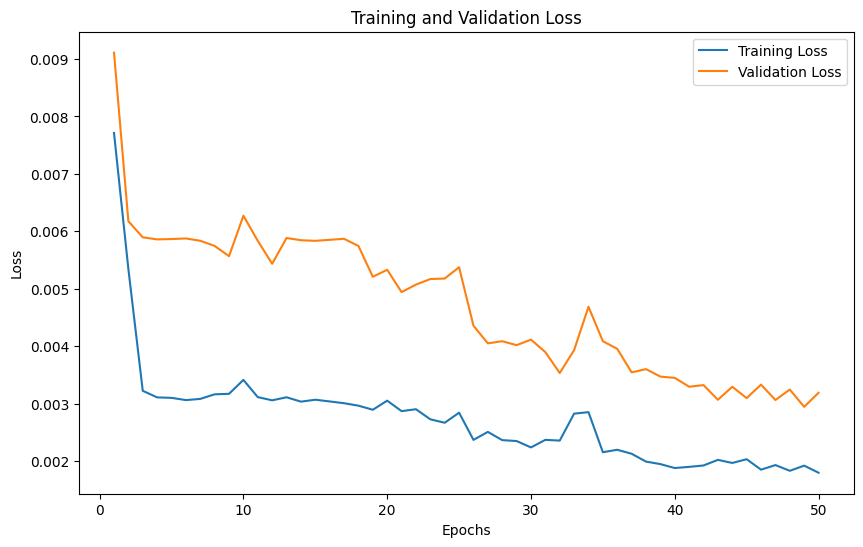

In [18]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

# =============================================================================
# Cell 1: Split data by date
# =============================================================================
unique_dates = LSTM_pos_data['Date'].drop_duplicates().sort_values()
train_cutoff = int(0.8 * len(unique_dates))
train_dates = unique_dates[:train_cutoff].tolist()
test_dates  = unique_dates[train_cutoff:].tolist()

# =============================================================================
# Cell 2: Create datasets
# =============================================================================
class StockDataset(Dataset):
    def __init__(self, df, selected_dates=None, time_window=5):
        if selected_dates is not None:
            df = df[df['Date'].isin(selected_dates)].copy()
        df.sort_values(by=["Ticker", "Date"], inplace=True)
        self.df = df.reset_index(drop=True)
        self.time_window = time_window
        self.feature_cols = [col for col in df.columns if col not in ["Date", "Ticker", "Class"]]
        self.groups = {ticker: group.sort_values(by="Date").reset_index(drop=True) 
                       for ticker, group in self.df.groupby("Ticker")}
        self.sequences = [(ticker, i) for ticker, group in self.groups.items() 
                          if len(group) >= time_window 
                          for i in range(len(group) - time_window + 1)]
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        ticker, start_idx = self.sequences[idx]
        group = self.groups[ticker].iloc[start_idx:start_idx + self.time_window]
        X = group[self.feature_cols].values.astype(np.float32)
        y = group["Class"].iloc[-1]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

train_dataset = StockDataset(LSTM_pos_data, selected_dates=train_dates)
test_dataset  = StockDataset(LSTM_pos_data, selected_dates=test_dates)

# =============================================================================
# Cell 3: Create DataLoaders (no shuffling to preserve order)
# =============================================================================
batch_size = 64  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# =============================================================================
# Cell 4: Initialize model
# =============================================================================
num_features = len(train_dataset.feature_cols)
input_size = num_features  

class ImprovedLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=3, dropout=0.2):
        super(ImprovedLSTMModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.lstm = nn.LSTM(128, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc_out = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        lstm_out, _ = self.lstm(x)
        out = self.fc_out(lstm_out[:, -1, :])
        return out.squeeze(1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedLSTMModel(input_size).to(device)

# =============================================================================
# Cell 5: Set up Loss Function, Optimizer, and Scheduler
# =============================================================================
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# =============================================================================
# Cell 6: Train the model
# =============================================================================
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, scheduler=None):
    train_losses, val_losses = [], []
    prev_lr = optimizer.param_groups[0]['lr']
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        if scheduler is not None:
            scheduler.step(avg_val_loss)
            current_lr = optimizer.param_groups[0]['lr']
            if current_lr != prev_lr:
                print(f"LR changed to: {current_lr}")
                prev_lr = current_lr
        
        if epoch % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    return train_losses, val_losses

num_epochs = 50
train_losses, val_losses = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, scheduler=scheduler)

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Test
# Test
# Test
# Test
# Test
# Test

DataFrame shape: (4547, 243)
Columns: ['Date', 'Ticker', 'article_score_1', 'title_score_1', 'mean_general_article_score_1', 'mean_general_title_score_1', 'Open_1', 'Close_1', 'High_1', 'Low_1', 'Volume_1', 'RSI_1', 'SMA_1', '%K_1', 'article_score_2', 'title_score_2', 'mean_general_article_score_2', 'mean_general_title_score_2', 'Open_2', 'Close_2', 'High_2', 'Low_2', 'Volume_2', 'RSI_2', 'SMA_2', '%K_2', 'article_score_3', 'title_score_3', 'mean_general_article_score_3', 'mean_general_title_score_3', 'Open_3', 'Close_3', 'High_3', 'Low_3', 'Volume_3', 'RSI_3', 'SMA_3', '%K_3', 'article_score_4', 'title_score_4', 'mean_general_article_score_4', 'mean_general_title_score_4', 'Open_4', 'Close_4', 'High_4', 'Low_4', 'Volume_4', 'RSI_4', 'SMA_4', '%K_4', 'article_score_5', 'title_score_5', 'mean_general_article_score_5', 'mean_general_title_score_5', 'Open_5', 'Close_5', 'High_5', 'Low_5', 'Volume_5', 'RSI_5', 'SMA_5', '%K_5', 'article_score_6', 'title_score_6', 'mean_general_article_score

c:\Users\argam\anaconda3\envs\FinTrendLSTM\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50], Train Loss: 0.0063, Val Loss: 0.0069
Epoch [2/50], Train Loss: 0.0039, Val Loss: 0.0076
Epoch [3/50], Train Loss: 0.0036, Val Loss: 0.0069
Epoch [4/50], Train Loss: 0.0034, Val Loss: 0.0059
Epoch [5/50], Train Loss: 0.0030, Val Loss: 0.0053
Epoch [6/50], Train Loss: 0.0027, Val Loss: 0.0047
Epoch [7/50], Train Loss: 0.0025, Val Loss: 0.0044
Epoch [8/50], Train Loss: 0.0021, Val Loss: 0.0042
Epoch [9/50], Train Loss: 0.0019, Val Loss: 0.0040
Epoch [10/50], Train Loss: 0.0020, Val Loss: 0.0034
Epoch [11/50], Train Loss: 0.0016, Val Loss: 0.0031
Epoch [12/50], Train Loss: 0.0019, Val Loss: 0.0036
Epoch [13/50], Train Loss: 0.0020, Val Loss: 0.0043
Epoch [14/50], Train Loss: 0.0023, Val Loss: 0.0032
Epoch [15/50], Train Loss: 0.0018, Val Loss: 0.0028
Epoch [16/50], Train Loss: 0.0015, Val Loss: 0.0028
Epoch [17/50], Train Loss: 0.0016, Val Loss: 0.0031
Epoch [18/50], Train Loss: 0.0019, Val Loss: 0.0034
Epoch [19/50], Train Loss: 0.0017, Val Loss: 0.0036
Epoch [20/50], Train 

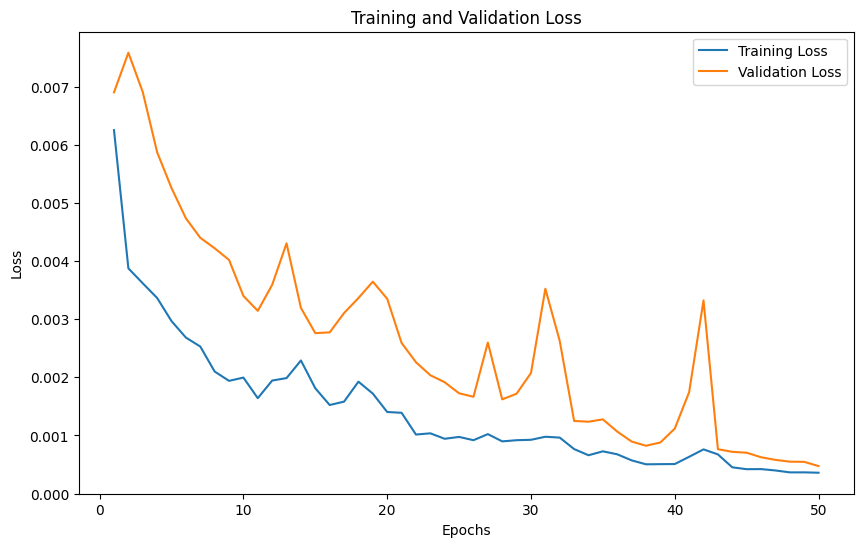

Test MSE: 0.0004
Test MAE: 0.0128
Test R2 Score: 0.9467
💾 Model saved!


In [19]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

# =============================================================================
# Cell 1: Check your transformed data
# =============================================================================
print(f"DataFrame shape: {LSTM_pos_data.shape}")
print(f"Columns: {LSTM_pos_data.columns.tolist()}")
print(f"Sample rows:\n{LSTM_pos_data.head()}")

# =============================================================================
# Cell 2: Split data by date
# =============================================================================
unique_dates = LSTM_pos_data['Date'].drop_duplicates().sort_values()
train_cutoff = int(0.8 * len(unique_dates))
train_dates = unique_dates[:train_cutoff].tolist()
test_dates  = unique_dates[train_cutoff:].tolist()

print(f"Total unique dates: {len(unique_dates)}")
print(f"Training dates: {len(train_dates)}")
print(f"Testing dates: {len(test_dates)}")

# =============================================================================
# Cell 3: Create datasets
# =============================================================================
class StockDataset(Dataset):
    """
    Creates a dataset for the LSTM from the transformed DataFrame.
    Each row in the DataFrame represents one stock–date pair with flattened features 
    (e.g., Open_1, Open_2, …, Open_20, etc.). This dataset constructs a sliding window
    of 5 consecutive days per ticker.
    """
    def __init__(self, df, selected_dates=None, time_window=5):
        if selected_dates is not None:
            df = df[df['Date'].isin(selected_dates)].copy()
        # Sort by Ticker and Date to preserve temporal order
        df.sort_values(by=["Ticker", "Date"], inplace=True)
        self.df = df.reset_index(drop=True)
        self.time_window = time_window
        
        # Feature columns: all except Date, Ticker, and Class
        self.feature_cols = [col for col in df.columns if col not in ["Date", "Ticker", "Class"]]
        
        # Group data by Ticker
        self.groups = {}
        for ticker, group in self.df.groupby("Ticker"):
            group = group.sort_values(by="Date").reset_index(drop=True)
            self.groups[ticker] = group
        
        # Build list of sequences as tuples: (ticker, start_index) for each ticker with enough days
        self.sequences = []
        for ticker, group in self.groups.items():
            if len(group) >= time_window:
                for i in range(len(group) - time_window + 1):
                    self.sequences.append((ticker, i))
                    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        ticker, start_idx = self.sequences[idx]
        group = self.groups[ticker].iloc[start_idx:start_idx + self.time_window]
        # X: features for the sliding window; shape: (time_window, number_of_features_per_day)
        X = group[self.feature_cols].values.astype(np.float32)
        # y: target is the exact Class value of the last day in the window (continuous regression target)
        y = group["Class"].iloc[-1]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

train_dataset = StockDataset(LSTM_pos_data, selected_dates=train_dates)
test_dataset  = StockDataset(LSTM_pos_data, selected_dates=test_dates)

# =============================================================================
# Cell 4: Create DataLoaders (no shuffling to preserve order)
# =============================================================================
batch_size = 64  # Reduced from 500 for better gradient updates
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# =============================================================================
# Cell 5: Initialize model
# =============================================================================
# In the transformed DataFrame, each row is a flattened vector of length = 20 * (original feature count).
# Here, self.feature_cols already represent that flattened vector.
num_features = len(train_dataset.feature_cols)
input_size = num_features  # Each day is represented by a vector of length input_size

class ImprovedLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.2):
        super(ImprovedLSTMModel, self).__init__()
        # The LSTM processes a sequence of 5 days; each day is a vector of length input_size.
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
        # No sigmoid here because we are doing regression on continuous class values.
    def forward(self, x):
        # x shape: (batch, time_window, input_size)
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Last timestep output
        return out.squeeze(1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedLSTMModel(input_size).to(device)
print(model)
print(f"Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# =============================================================================
# Cell 6: Set up Loss Function, Optimizer, and Scheduler
# =============================================================================
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# =============================================================================
# Cell 7: Train the model
# =============================================================================
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, scheduler=None):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            # X_batch already has shape (batch, time_window, input_size)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        if scheduler is not None:
            scheduler.step(avg_val_loss)
    return train_losses, val_losses

num_epochs = 50
train_losses, val_losses = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, scheduler=scheduler)

# =============================================================================
# Cell 8: Plot training history
# =============================================================================
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# =============================================================================
# Cell 9: Evaluate the model
# =============================================================================
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            all_preds.extend(outputs.cpu().numpy())  # Continuous predictions
            all_labels.extend(y_batch.cpu().numpy())
    mse_val = mean_squared_error(all_labels, all_preds)
    # For reporting, you might threshold if needed; here we report regression metrics
    return np.array(all_labels), np.array(all_preds), mse_val

true_labels, pred_values, mse_val = evaluate_model(model, test_loader)

print(f"Test MSE: {mse_val:.4f}")

# =============================================================================
# Additional: Evaluation Metrics for Regression
# =============================================================================
# Optionally, you could compute additional metrics such as MAE, R2, etc.
from sklearn.metrics import mean_absolute_error, r2_score
mae_val = mean_absolute_error(true_labels, pred_values)
r2_val = r2_score(true_labels, pred_values)
print(f"Test MAE: {mae_val:.4f}")
print(f"Test R2 Score: {r2_val:.4f}")

# =============================================================================
# Cell 10: Save the model
# =============================================================================
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'feature_cols': train_dataset.feature_cols,
}, "lstm_stock_model.pth")

print("💾 Model saved!")

# Test
# Test
# Test
# Test
# Test
# Test

# Explanation

Padding:
– We pad (or truncate) each day’s data so that every (Ticker, Date) day becomes a matrix of exactly 20 rows × num_features.
– This flattened matrix (of length 20 × num_features) is then fed into the “DailyEncoder” which converts it into a day‐embedding vector (of size day_emb_size, set here to 128).

Sliding Window Sequences:
– We form sequences of 5 consecutive days for each ticker using a sliding window.
– This sliding window naturally ensures that (except at the very beginning and very end) each day appears in 5 different sequences—in different positions (first, second, …, fifth).
– In other words, if a stock has T days in the data, you’ll create T‑time_window sequences, which maximizes the usage of each day’s information.

In [20]:
# Prepare dataset
print("Loading dataset...")
final_df = final_dataframes['bigrams']  # 🔹 Use bigrams dataframe instead of pos
final_df.sort_values(by=['Date'], inplace=True)
dataset = StockDataset(final_df, time_window)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print(f"Dataset split into {train_size} training and {test_size} testing samples")

# Debug first batch
first_batch = next(iter(train_loader))
print(f"First batch shape: X={first_batch[0].shape}, Y={first_batch[1].shape}")
print(f"First batch labels: {first_batch[1].tolist()}")

# Model setup
input_size = len(final_df.columns) - 2  # Exclude Date and Class
print(f"Initializing model with input size: {input_size}")
bigrams_model = LSTM(input_size, hidden_size, num_layers).to(device)
criterion = nn.MSELoss()  # Regression loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train model

epoch_times = []  # Track total training time
print("Starting training...")
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()  # Start time for this epoch
    epoch_loss = 0

    for i, (sequences, labels) in enumerate(train_loader):
        sequences, labels = sequences.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = bigrams_model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        if (i + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    epoch_time = time.time() - epoch_start  # Compute epoch duration
    epoch_times.append(epoch_time)  # Save time for each epoch
    print(f"Epoch {epoch+1} completed in {epoch_time:.2f} seconds, Avg Loss: {epoch_loss / len(train_loader):.4f}")

total_training_time = sum(epoch_times)  # Compute total training time
print(f"Training completed in {total_training_time / 60:.2f} minutes")

# Test model
print("Starting evaluation...")
with torch.no_grad():
    test_loss = 0
    for sequences, labels in test_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        outputs = bigrams_model(sequences)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
    
    mse = test_loss / len(test_loader)
    rmse = sqrt(mse)
    print(f"Test Loss (MSE): {mse:.4f}, RMSE: {rmse:.4f}")

# Save model
torch.save(bigrams_model.state_dict(), "stock_lstm_bigrams.pth")
print("Model saved!")


Loading dataset...


NameError: name 'time_window' is not defined

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import time
from math import sqrt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyper-parameters
num_epochs = 10          # More epochs for better training
batch_size = 63          # Process 63 stocks at a time
learning_rate = 0.001
time_window = 21         # 21-day sequences
hidden_size = 128
num_layers = 3
embed_dim = 768          # Dimension of each embedding vector

#############################################
# Dataset for WE DataFrame
#############################################
class WEDataset(Dataset):
    def __init__(self, df, time_window):
        print("Initializing WEDataset...")
        self.data = df.copy().reset_index(drop=True)
        self.time_window = time_window
        
        # Convert 'Ticker' to categorical codes (if not already numeric)
        self.data['Ticker'] = self.data['Ticker'].astype('category').cat.codes
        
        # Extract numeric features: drop Date, Class, article_embeddings, title_embeddings
        self.numeric_features = self.data.drop(columns=['Date', 'Class', 'article_embeddings', 'title_embeddings'])\
                                           .select_dtypes(include=[np.number]).astype(np.float32)
        self.labels = self.data['Class'].astype(np.float32)  # Regression target
        
        # Embedding features: convert stored objects to numpy arrays (if not already)
        self.article_embeddings = self.data['article_embeddings'].apply(lambda x: np.array(x, dtype=np.float32))
        self.title_embeddings   = self.data['title_embeddings'].apply(lambda x: np.array(x, dtype=np.float32))
        
        # Debug prints
        print("WEDataset initialized with", len(self.data), "rows")
        print("Numeric features shape:", self.numeric_features.shape)
        print("Sample article embedding (first row) - first 5 values:", self.article_embeddings.iloc[0][:5])
        print("Target (Class) distribution:", self.data['Class'].describe())
    
    def __len__(self):
        return len(self.data) - self.time_window
    
    def __getitem__(self, idx):
        # Get sequences for the time window
        x_numeric = self.numeric_features.iloc[idx: idx+self.time_window].values  # shape: [time_window, num_numeric]
        x_article = np.stack(self.article_embeddings.iloc[idx: idx+self.time_window].values)  # shape: [time_window, embed_dim]
        x_title   = np.stack(self.title_embeddings.iloc[idx: idx+self.time_window].values)      # shape: [time_window, embed_dim]
        y = self.labels.iloc[idx + self.time_window]  # Regression target
        
        return (torch.tensor(x_numeric, dtype=torch.float32),
                torch.tensor(x_article, dtype=torch.float32),
                torch.tensor(x_title, dtype=torch.float32),
                torch.tensor(y, dtype=torch.float32))

#############################################
# Prepare Dataset and DataLoader for WE data
#############################################
print("Loading WE dataset...")
we_df = final_dataframes['word_embeddings']  # Use the WE dataframe key
we_df.sort_values(by=['Date'], inplace=True)
dataset = WEDataset(we_df, time_window)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
print(f"Dataset split into {train_size} training and {test_size} testing samples")

# Debug first batch
first_batch = next(iter(train_loader))
print(f"First batch shapes: X_numeric={first_batch[0].shape}, X_article={first_batch[1].shape}, X_title={first_batch[2].shape}, Y={first_batch[3].shape}")
print(f"First batch targets: {first_batch[3].tolist()}")

#############################################
# Define the WE_LSTM model
#############################################
class WE_LSTM(nn.Module):
    def __init__(self, num_input_size, hidden_size, num_layers, embed_dim):
        super(WE_LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        # LSTM for numeric features
        self.lstm = nn.LSTM(num_input_size + 2, hidden_size, num_layers, batch_first=True)
        # Note: We'll add 2 scalars (one from article, one from title) to the numeric features per time step
        
        # Feedforward network for article embeddings (applied per time step)
        self.article_net = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        # Feedforward network for title embeddings (applied per time step)
        self.title_net = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        # Final layer to produce regression output from LSTM output
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x_numeric, x_article, x_title):
        # x_numeric shape: [batch, time_window, num_input_size]
        # x_article and x_title shape: [batch, time_window, embed_dim]
        batch_size, t, _ = x_numeric.shape
        
        # Process article embeddings per time step: flatten, process, and reshape
        article_out = self.article_net(x_article.view(-1, x_article.shape[-1]))  # shape: [batch*time_window, 1]
        article_out = article_out.view(batch_size, t, 1)  # shape: [batch, time_window, 1]
        
        # Process title embeddings similarly
        title_out = self.title_net(x_title.view(-1, x_title.shape[-1]))  # shape: [batch*time_window, 1]
        title_out = title_out.view(batch_size, t, 1)  # shape: [batch, time_window, 1]
        
        # Concatenate numeric features with the 2 scalar outputs along last dimension
        augmented_input = torch.cat((x_numeric, article_out, title_out), dim=2)  # shape: [batch, time_window, num_input_size+2]
        
        # Process through LSTM
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        lstm_out, _ = self.lstm(augmented_input, (h0, c0))  # shape: [batch, time_window, hidden_size]
        lstm_last = lstm_out[:, -1, :]  # shape: [batch, hidden_size]
        
        # Final regression output
        out = self.fc(lstm_last)  # shape: [batch, 1]
        return out.squeeze(1)  # shape: [batch]

#############################################
# Model Setup
#############################################
# Determine numeric input size: all numeric columns except Date, Class, article_embeddings, title_embeddings
num_input_size = we_df.drop(columns=['Date', 'Class', 'article_embeddings', 'title_embeddings'])\
                      .select_dtypes(include=[np.number]).shape[1]
print(f"Initializing WE_LSTM model with numeric input size: {num_input_size}")
we_model = WE_LSTM(num_input_size, hidden_size, num_layers, embed_dim).to(device)
criterion = nn.MSELoss()  # Regression loss function
optimizer = torch.optim.Adam(we_model.parameters(), lr=learning_rate)

#############################################
# Training Loop
#############################################
epoch_times = []
print("Starting training...")
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    epoch_loss = 0
    for i, (x_numeric, x_article, x_title, labels) in enumerate(train_loader):
        x_numeric, x_article, x_title, labels = x_numeric.to(device), x_article.to(device), x_title.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = we_model(x_numeric, x_article, x_title)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
        if (i + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)
    print(f"Epoch {epoch+1} completed in {epoch_time:.2f} seconds, Avg Loss: {epoch_loss / len(train_loader):.4f}")

total_training_time = sum(epoch_times)
print(f"Training completed in {total_training_time / 60:.2f} minutes")

#############################################
# Evaluation Loop
#############################################
print("Starting evaluation...")
with torch.no_grad():
    test_loss = 0
    for x_numeric, x_article, x_title, labels in test_loader:
        x_numeric, x_article, x_title, labels = x_numeric.to(device), x_article.to(device), x_title.to(device), labels.to(device)
        outputs = we_model(x_numeric, x_article, x_title)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
    
    mse = test_loss / len(test_loader)
    rmse = sqrt(mse)
    print(f"Test Loss (MSE): {mse:.4f}, RMSE: {rmse:.4f}")

#############################################
# Save Model
#############################################
torch.save(we_model.state_dict(), "stock_we_lstm_model.pth")
print("Model saved!")


Using device: cpu
Loading WE dataset...
Initializing WEDataset...
WEDataset initialized with 55723 rows
Numeric features shape: (55723, 13)
Sample article embedding (first row) - first 5 values: [ 0.1187183  0.3063625 -0.6674092  1.4475749  2.7075114]
Target (Class) distribution: count    55723.000000
mean        -0.113006
std          0.067387
min         -0.753257
25%         -0.135012
50%         -0.126511
75%         -0.110802
max          0.538508
Name: Class, dtype: float64
Dataset split into 44561 training and 11141 testing samples
First batch shapes: X_numeric=torch.Size([63, 21, 13]), X_article=torch.Size([63, 21, 768]), X_title=torch.Size([63, 21, 768]), Y=torch.Size([63])
First batch targets: [-0.1506516933441162, -0.12268810719251633, -0.39267802238464355, -0.13157671689987183, -0.1244800016283989, -0.13894259929656982, -0.12323027104139328, -0.09351910650730133, -0.08531118184328079, -0.1421089470386505, -0.11503484100103378, -0.13341738283634186, -0.1047077402472496, -0.1